**Data mining Project - University of Pisa, acedemic year 2023/24**
 
**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa
 
# Data and indicators understanding by state for clustering


The goal of this section of the data analysis is to examine the distribution of data for each state in the dataset. The main purpose is to select a specific state and identify its most relevant characteristics in order to subsequently apply clustering algorithms.

This phase of the analysis also aims to determine if there is a state that can serve as a well-representative sample of the entire dataset. The objective is to assess whether the information derived from clustering algorithms applied to a single state can be generalized and extended to the entire dataset.

We import the libraries:

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

We load the dataset and a the list of indicators conteined in dataset:

In [2]:
incidents_df = pd.read_csv(
    '../data/incidents_indicators.csv',
    index_col=0,
    parse_dates=['date', 'date_original'],
    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d')
)

In [3]:
incidents_df.head(2)

date date_original    year  month  day  day_of_week         state  \
0 2015-05-02    2015-05-02  2015.0      5    2            5       INDIANA   
1 2017-04-03    2017-04-03  2017.0      4    3            0  PENNSYLVANIA   

                         address  latitude  longitude  ... n_unharmed_prop  \
0  Lafayette Road and Pike Plaza   39.8322   -86.2492  ...             0.0   
1                      5647 US 6   41.6645   -78.7856  ...             0.0   

  n_males_prop log_n_males_mean_ratio  surprisal_n_males  \
0          1.0              -0.284676           1.290677   
1          1.0              -0.230767           0.341037   

   surprisal_characteristics  n_arrested_prop log_n_participants_mean_ratio  \
0                   1.812630              0.0                     -0.485560   
1                   2.662965              0.0                     -0.384686   

   surprisal_n_participants n_participants surprisal_day  
0                  1.098032            1.0      5.513070  
1                  0.662965            1.0      3.247928  

[2 rows x 91 columns]

In [4]:
f = open('../data/indicators_names.json')
ind_names_list = json.loads(f.read())

### Number of not NaN Entries by State

We group data by state, and subsequently by state, county, and city, in order to understand how much data we have for each geographical region.

In [5]:
incidents_df.groupby('state').size().sort_values(ascending=False).head(15)

state
ILLINOIS          17554
CALIFORNIA        16291
FLORIDA           15005
TEXAS             13514
OHIO              10243
NEW YORK           9710
PENNSYLVANIA       8925
GEORGIA            8896
NORTH CAROLINA     8730
LOUISIANA          8096
TENNESSEE          7614
SOUTH CAROLINA     6937
MISSOURI           6623
MICHIGAN           6130
MASSACHUSETTS      5980
dtype: int64

In [6]:
incidents_df.groupby(['state', 'county', 'city']).size().sort_values(ascending=False).head(15)

state          county              city            
ILLINOIS       Cook County         Chicago             11108
LOUISIANA      Orleans Parish      New Orleans          3008
PENNSYLVANIA   Philadelphia        Philadelphia         2723
WISCONSIN      Milwaukee County    Milwaukee            2406
TENNESSEE      Shelby County       Memphis              2297
FLORIDA        Duval County        Jacksonville         2252
TEXAS          Harris County       Houston              2232
INDIANA        Marion County       Indianapolis         1818
MASSACHUSETTS  Suffolk County      Boston               1721
MICHIGAN       Wayne County        Detroit              1596
OHIO           Cuyahoga County     Cleveland            1595
TEXAS          Bexar County        San Antonio          1463
CALIFORNIA     Alameda County      Oakland              1451
               Los Angeles County  Los Angeles          1416
NEW YORK       Brooklyn            City of New York     1367
dtype: int64

We first notice that the state with the most entries is Illinois, with 17554 entries. The majority of entries for this state are in Chicago, Cook County, which is also the city with the most entries in the dataset. Following that, we have California and Florida states, which have 16291 and 15005 entries, respectively.

In order to visualize the data on a map, we include a code for each state from an [official list of states](https://www2.census.gov/geo/docs/reference/state.txt') that is compatible with the Plotly library used for plotting.

In [7]:
usa_states_df = pd.read_csv(
    'https://www2.census.gov/geo/docs/reference/state.txt',
    sep='|',
    dtype={'STATE': str, 'STATE_NAME': str}
)
usa_name_alphcode = usa_states_df.set_index('STATE_NAME').to_dict()['STUSAB']

We create a dataset representing data from the dataset, grouped by state, and containing the count of non-NaN entries for each indices in each state.

In [8]:
incidents_grouped_by_state = incidents_df.groupby(['state']).size().sort_values(ascending=False).to_frame().reset_index()
incidents_grouped_by_state.rename(columns={0: 'not_nan_entries'}, inplace=True)

incidents_grouped_by_state['px_code'] = incidents_grouped_by_state['state'].str.title().map(usa_name_alphcode)
for attribute in ['city', 'county'] + ind_names_list + ['severity', 'n_participants', 'surprisal_characteristics']:
    incidents_grouped_by_state[attribute+'_count'] = incidents_df.groupby('state')[
        attribute].count().sort_values(ascending=False).to_frame().reset_index()[attribute]

Establishing plot utilities:

In [9]:
hover_data = {
    'px_code': False,
    'not_nan_entries': True,
    'county_count': True,
    'city_count': True, 
    'lat_proj_count': True,
    'location_imp_count': True,
    'age_range_count': True,
    'surprisal_min_age_count': True,
    'n_child_prop_count': True,
    'surprisal_age_groups_count': True,
    'severity_count': True,
    'n_unharmed_prop_count': True,
    'n_males_prop_count': True,
    'surprisal_n_males_count': True,
    'n_arrested_prop_count': True,
    'n_participants_count': True,
    'surprisal_characteristics_count': True,
}

labels={
    'not_nan_entries':'Number of entries',
    'city_count': 'Number of cities',
    'county_count': 'Number of counties',
    'lat_proj_count': 'Latidude and Longitude', #'lat_proj_count, lon_proj_count'
    'location_imp_count': 'Location Importance and Address Type Suprisal', #location_imp_count, surprisal_address_type_count',
    'age_range_count': 'Age attributes', # 'age_range_count, avg_age_count', 
    'surprisal_min_age_count': 'Min Age Suprisal',
    'n_child_prop_count': 'Child and Teen Proportion',
    'surprisal_age_groups_count': 'Age Groups Surprisal', # 'surprisal_age_groups_count, surprisal_n_child_count
    'surprisal_n_child_count': 'Age Groups Suprisal',
    'severity_count': 'Severity Indices',
    'n_unharmed_prop_count': 'Unharmed Proportion',
    'n_males_prop_count': 'Males Proportion',
    'surprisal_n_males_count': 'Males Surprisal',
    'n_arrested_prop_count': 'Arrested Proportion',
    'n_participants_count': 'Number of Participants',
    'surprisal_characteristics_count': 'Characteristics Surprisal',
}

In [10]:
counts_columns = ['city_count', 'county_count'] + [
    indices + '_count' for indices in ind_names_list] + [
    'severity_count', 'n_participants_count', 'surprisal_characteristics_count']

We plot on a USA map the number of non-NaN entries by state for indices and numerical features.

In [11]:
fig = px.choropleth(incidents_grouped_by_state, 
    color='not_nan_entries',
    locations='px_code',
    locationmode="USA-states",
    scope="usa",
    title="Number of non-NaN Entries by State", 
    hover_name='state',
    hover_data=hover_data,
    labels=labels
)

fig.show()

Below, we create ratios for each index and numerical attribute, expressing the ratio of null entries for each attribute in the same state to the total number of entries with all non-null values for that state. The ratios have been scaled between 0 and 100 for visualization purposes and are represented in choropleth maps.

In [12]:
# create ration for number of NaN entries for each attributes by state wrt the total number of entries by state
ratio_columns = []

for attribute in ['city', 'county'] + ind_names_list + ['severity', 'n_participants']:
    incidents_grouped_by_state['nan_entries_'+attribute] = incidents_df[incidents_df[attribute].isna()
        ].groupby('state').size().sort_values(ascending=False).to_frame().reset_index()[0]
    
    incidents_grouped_by_state['nan_entries_'+attribute+'_ratio'] = 100*incidents_grouped_by_state['nan_entries_'+attribute
        ] / incidents_grouped_by_state['not_nan_entries']
    
    ratio_columns += ['nan_entries_'+attribute+'_ratio']

In [13]:
incidents_grouped_by_state[['state']+ratio_columns].head(4)

state  nan_entries_city_ratio  nan_entries_county_ratio  \
0    ILLINOIS               23.755269                 14.925373   
1  CALIFORNIA               14.756614                 14.449696   
2     FLORIDA               13.395535                 15.301566   
3       TEXAS               13.926299                 14.843866   

   nan_entries_lat_proj_ratio  nan_entries_lon_proj_ratio  \
0                    5.554290                    5.554290   
1                    4.726536                    4.726536   
2                    4.751749                    4.751749   
3                    4.328844                    4.328844   

   nan_entries_location_imp_ratio  nan_entries_surprisal_address_type_ratio  \
0                        5.554290                                 15.141848   
1                        4.726536                                 14.848689   
2                        4.751749                                 14.868377   
3                        4.328844                                 11.928371   

   nan_entries_age_range_ratio  nan_entries_avg_age_ratio  \
0                    41.266948                  41.266948   
1                    42.158247                  42.158247   
2                    42.232589                  42.232589   
3                    29.317745                  29.317745   

   nan_entries_surprisal_min_age_ratio  ...  nan_entries_n_injured_prop_ratio  \
0                            42.565797  ...                         13.364475   
1                            44.067276  ...                          8.808545   
2                            45.031656  ...                          8.170610   
3                            31.730058  ...                          8.406097   

   nan_entries_n_unharmed_prop_ratio  nan_entries_n_males_prop_ratio  \
0                          13.717671                       20.018229   
1                          10.398379                       15.358173   
2                          10.196601                       15.068311   
3                           9.715850                       12.771940   

   nan_entries_surprisal_n_males_ratio  \
0                            31.366070   
1                            28.181204   
2                            28.563812   
3                            21.992008   

   nan_entries_surprisal_characteristics_ratio  \
0                                    13.034066   
1                                    13.179056   
2                                    14.088637   
3                                    10.996004   

   nan_entries_n_arrested_prop_ratio  nan_entries_n_participants_ratio  \
0                          13.717671                         13.364475   
1                          10.398379                          8.808545   
2                          10.196601                          8.170610   
3                           9.715850                          8.406097   

   nan_entries_surprisal_day_ratio  nan_entries_severity_ratio  \
0                        13.034066                   21.772815   
1                        13.179056                   18.009944   
2                        14.088637                   19.226924   
3                        10.996004                   17.233980   

   nan_entries_n_participants_ratio  
0                         13.364475  
1                          8.808545  
2                          8.170610  
3                          8.406097  

[4 rows x 24 columns]

In [34]:
from plot_utils import plot_not_nan_entries_by_state

labels_list = ['city', 'county'] + ind_names_list + ['severity', 'n_participants']

plot_not_nan_entries_by_state(df=incidents_grouped_by_state, 
    labels=labels_list[:8],
    attribute_list=ratio_columns[:8], n_rows=2, n_columns=4)
plot_not_nan_entries_by_state(df=incidents_grouped_by_state, labels=labels_list[9:17],
    attribute_list=ratio_columns[8:16], n_rows=2, n_columns=4)
plot_not_nan_entries_by_state(df=incidents_grouped_by_state, labels=labels_list[17:],
    attribute_list=ratio_columns[16:], n_rows=2, n_columns=4)

In the choropleth maps above, values of ratios for null entries are visualized for each attribute, categorized by state.

The ratio scale is depicted using colors ranging from blue to yellow: cooler colors represent lower ratios, indicating states with fewer null entries in relation to the total, while warmer colors represent higher ratios. A cooler color suggests a state with a lower number of null entries for that feature, which is preferable.

Note that the choropleth maps are presented in three separate figures, each with a different color scale, in order to best represent the ranges of ratios for the displayed attributes.

We can observe that, across all states, features related to age have the highest number of missing entries. In all features, Texas exhibits lower ratio values compared to other states, followed closely by Illinois and California.

Below, we have presented the mean values of the ratios among states to highlight which features have fewer missing entries. Consistent with the observations above, geographic data has the fewest missing values as a percentage, followed by indices representing incident characteristics and the number of participants.

In [15]:
incidents_grouped_by_state[ratio_columns].describe().mean().sort_values(ascending=True)

nan_entries_lat_proj_ratio                     10.748525
nan_entries_lon_proj_ratio                     10.748525
nan_entries_location_imp_ratio                 10.748525
nan_entries_county_ratio                       12.204357
nan_entries_surprisal_day_ratio                14.625998
nan_entries_surprisal_characteristics_ratio    14.625998
nan_entries_n_participants_ratio               15.772916
nan_entries_n_participants_ratio               15.772916
nan_entries_n_injured_prop_ratio               15.772916
nan_entries_n_killed_prop_ratio                15.772916
nan_entries_n_arrested_prop_ratio              16.616656
nan_entries_n_unharmed_prop_ratio              16.616656
nan_entries_city_ratio                         16.649922
nan_entries_surprisal_address_type_ratio       16.741123
nan_entries_n_teen_prop_ratio                  20.664270
nan_entries_n_child_prop_ratio                 20.664270
nan_entries_n_males_prop_ratio                 20.683733
nan_entries_severity_ratio     

Below, we have presented bar plots to visualize the percentages of missing values for each attribute by state (in orange) relative to the total number of entries (in blue) for that state.

The percentages displayed above each bar represent the proportion of missing values for the respective features.

These percentages are calculated based on the total number of entries for the state. In contrast, in the choropleth maps and the data frame above, the ratios are calculated based on the number of entries with all non-null values, resulting in higher values.

We have chosen to calculate and represent both ratios to provide a more comprehensive view of the dataset, aiming to identify the most suitable features for each state to use in clustering algorithms.

Note that the y-axis of the bar plots is in a logarithmic scale.

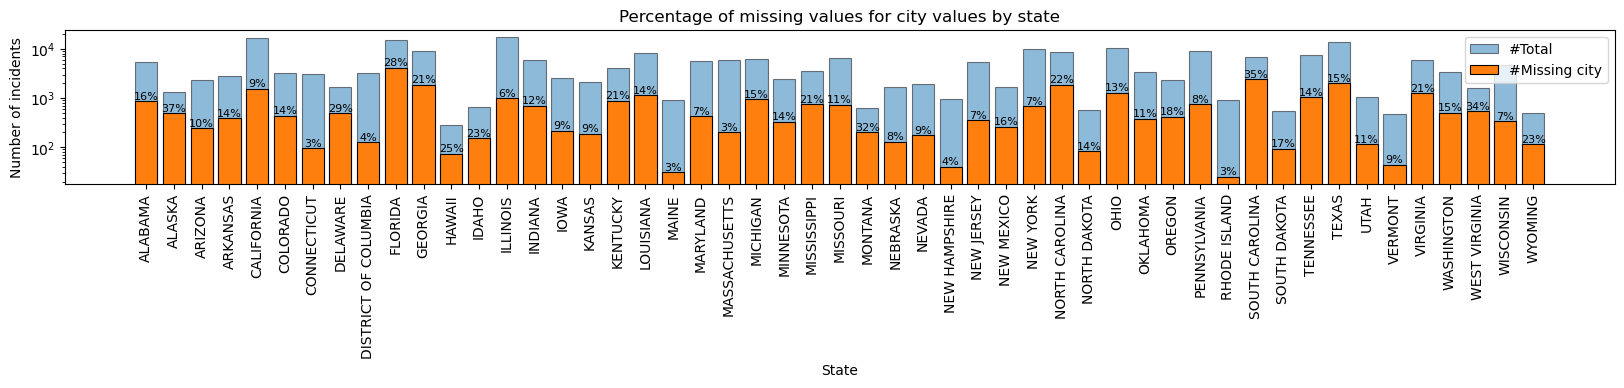

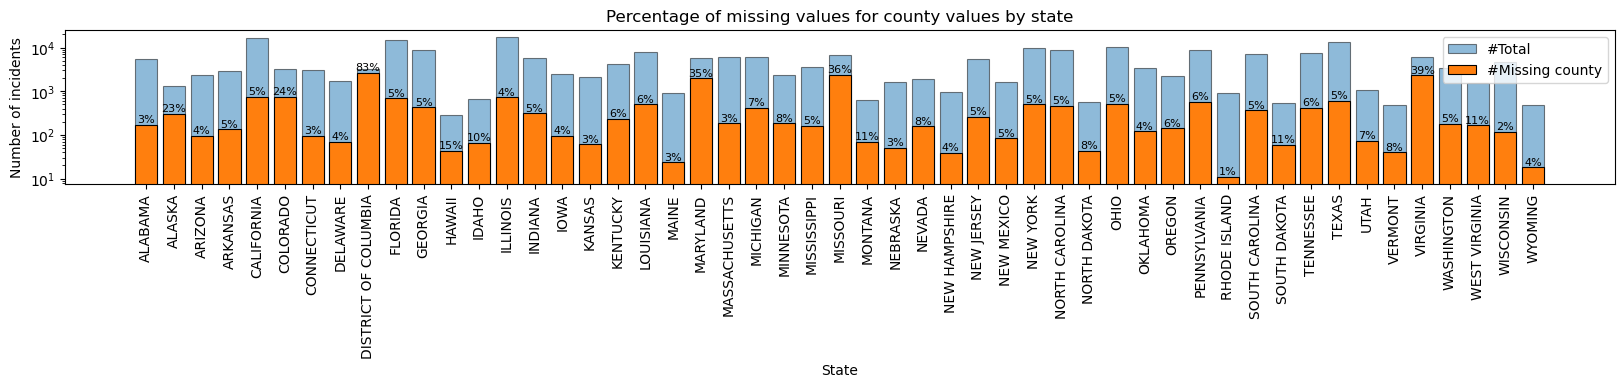

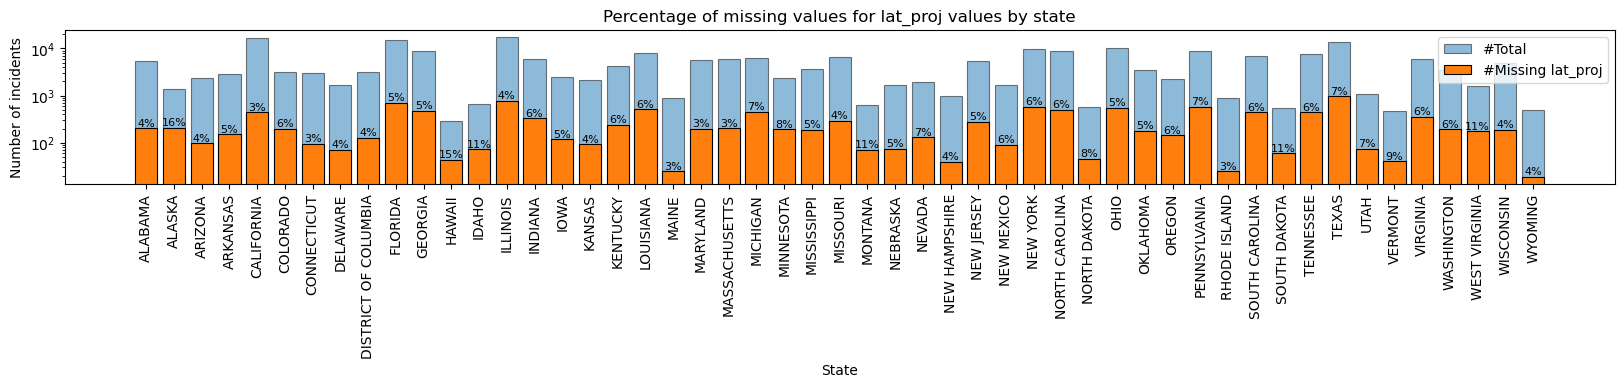

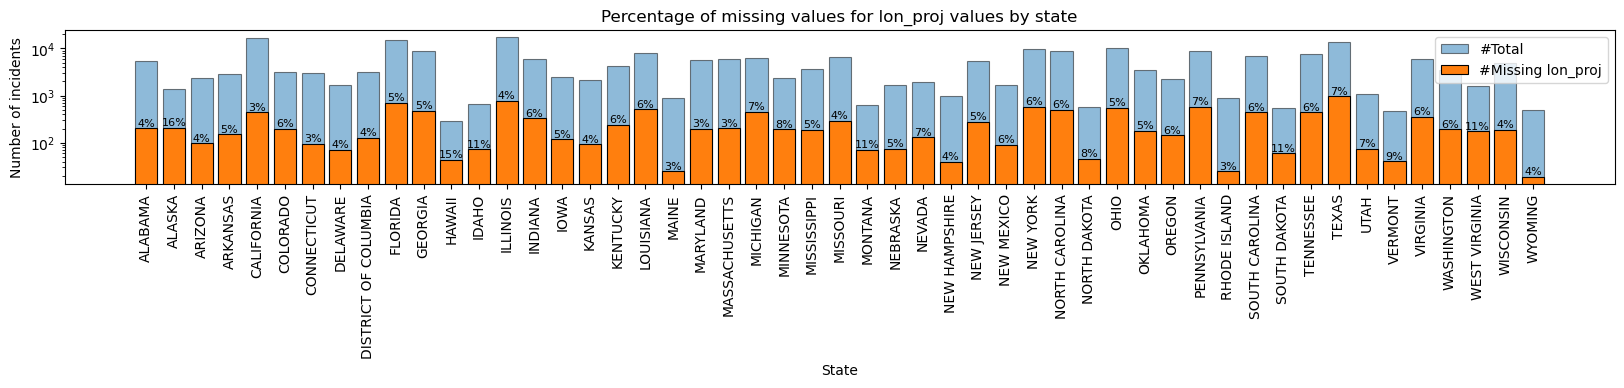

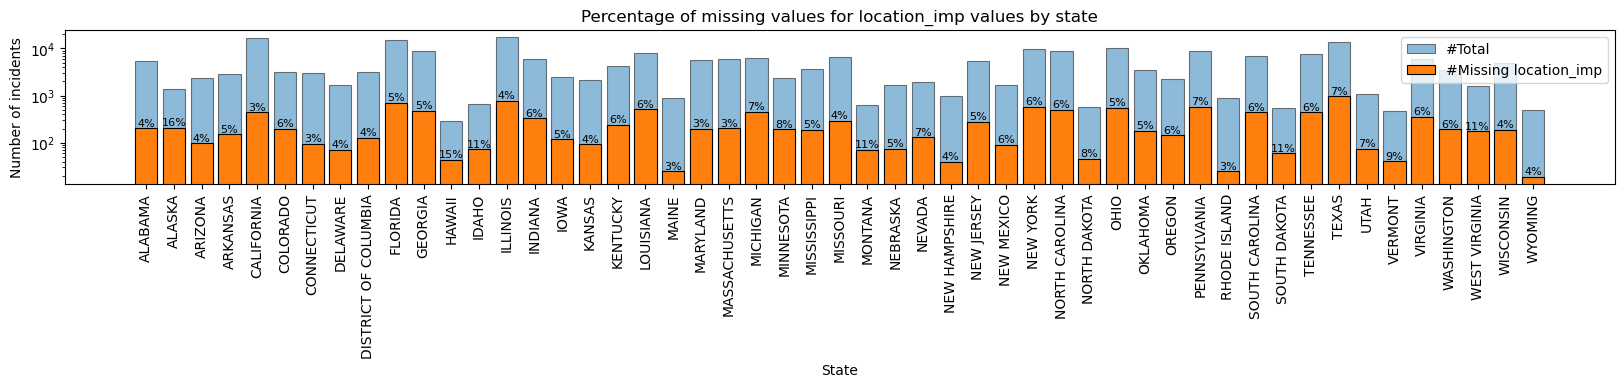

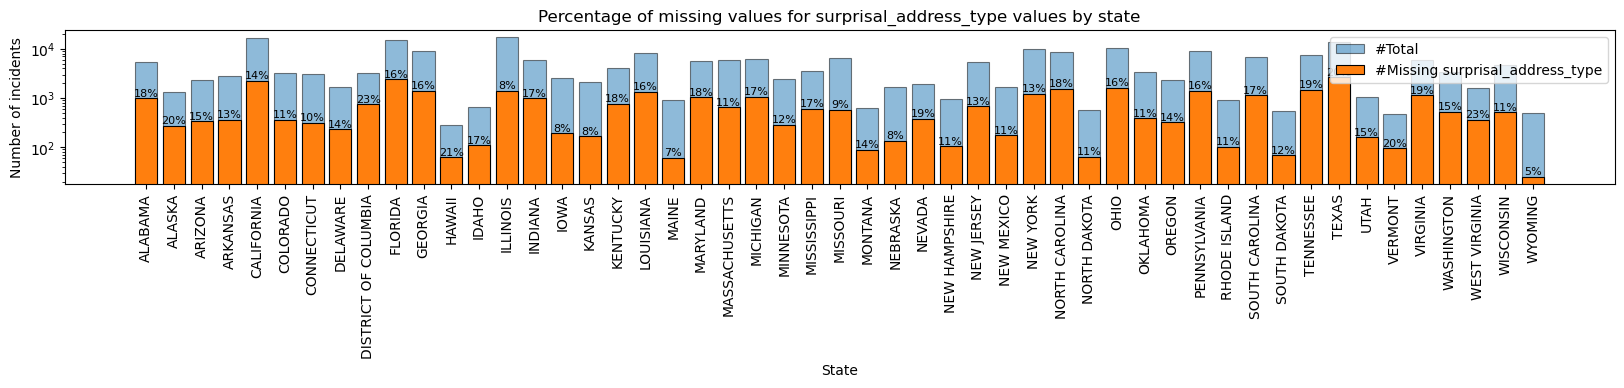

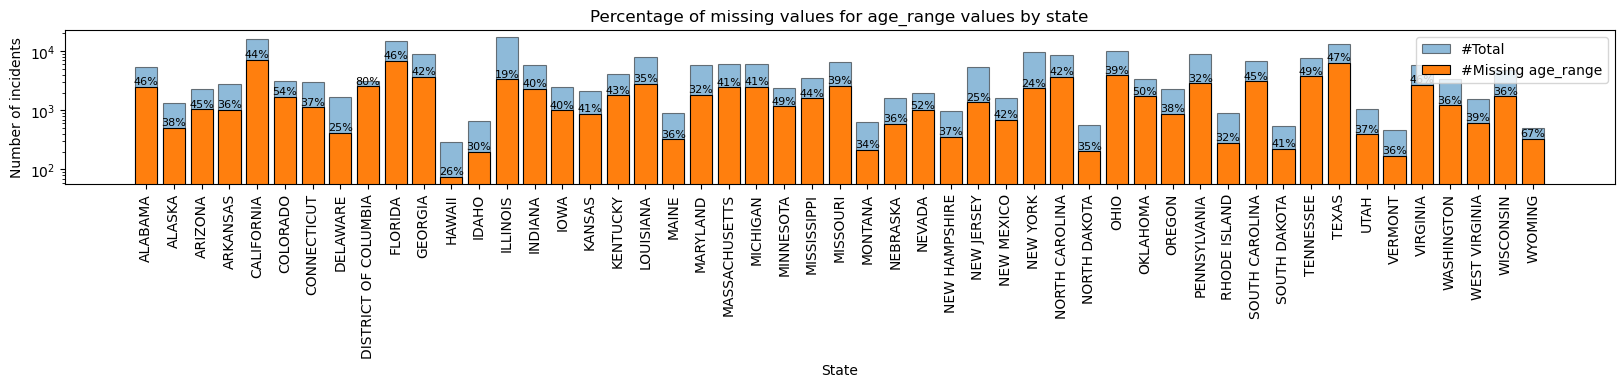

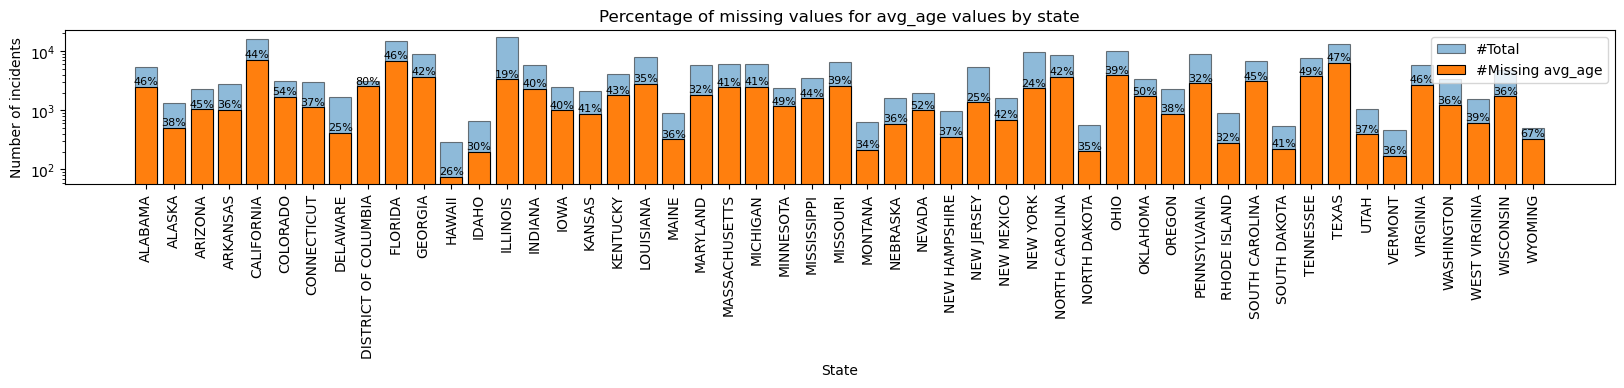

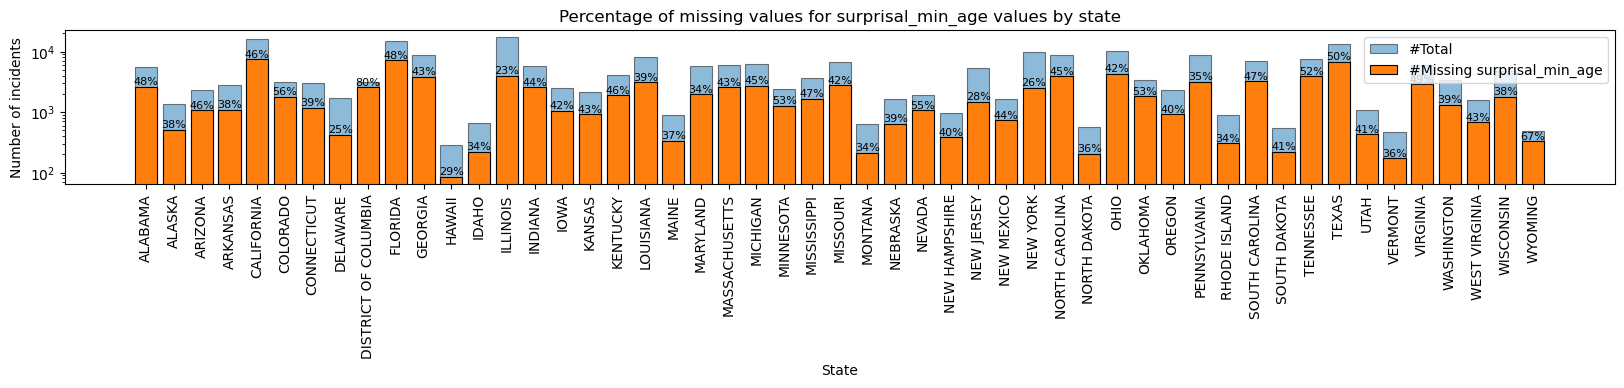

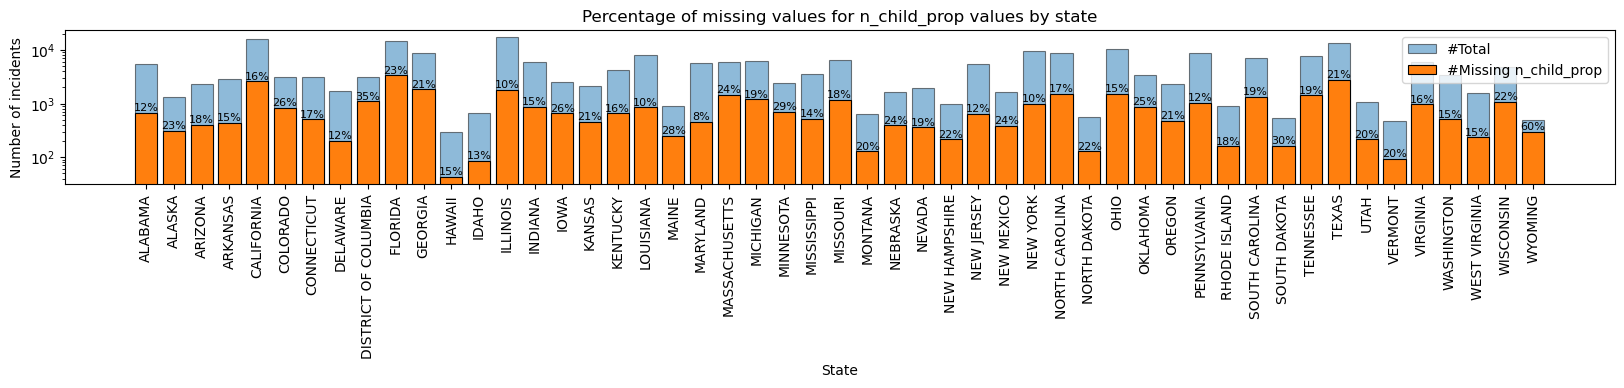

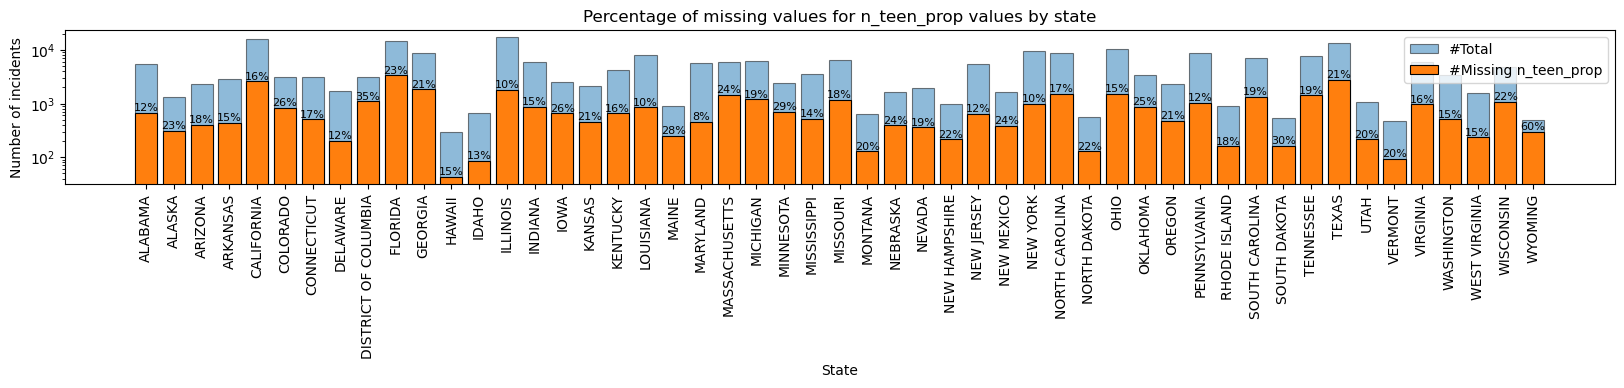

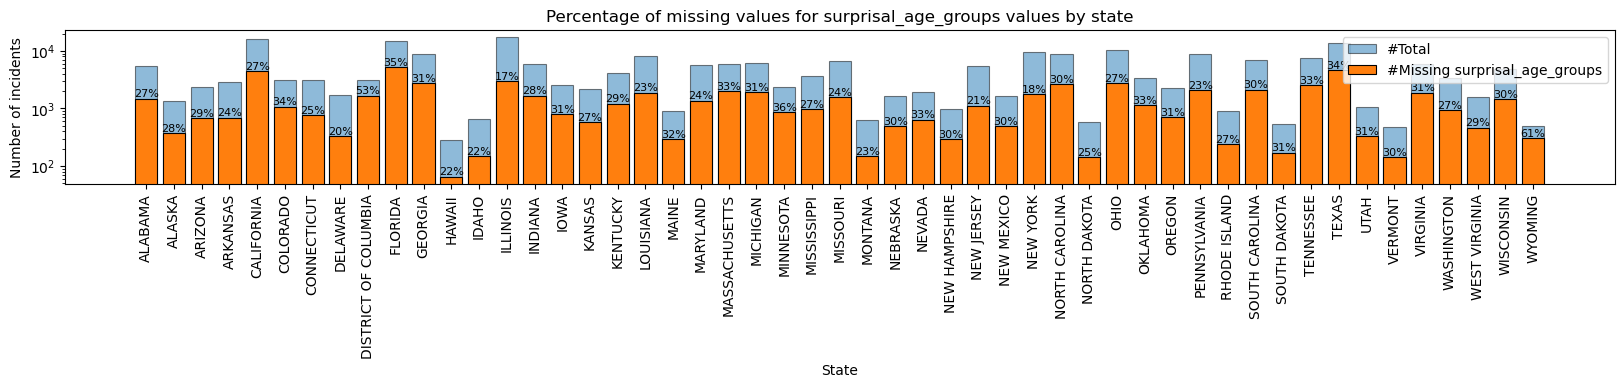

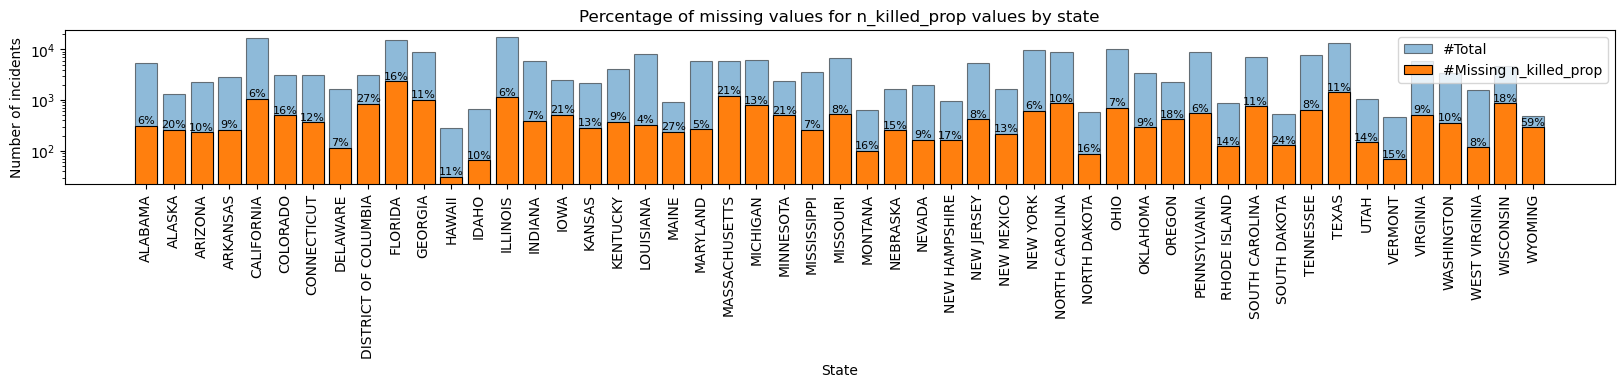

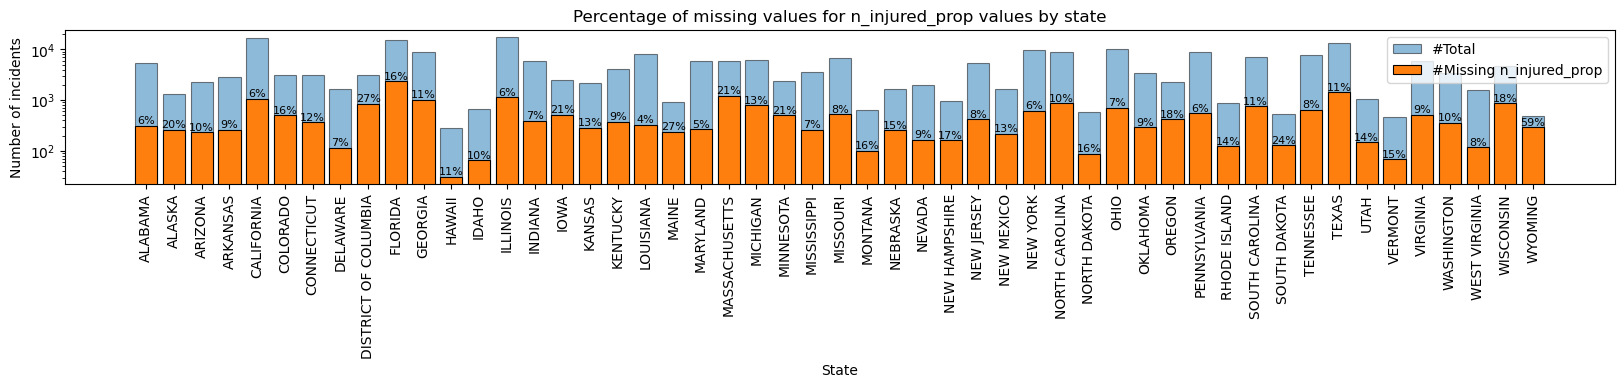

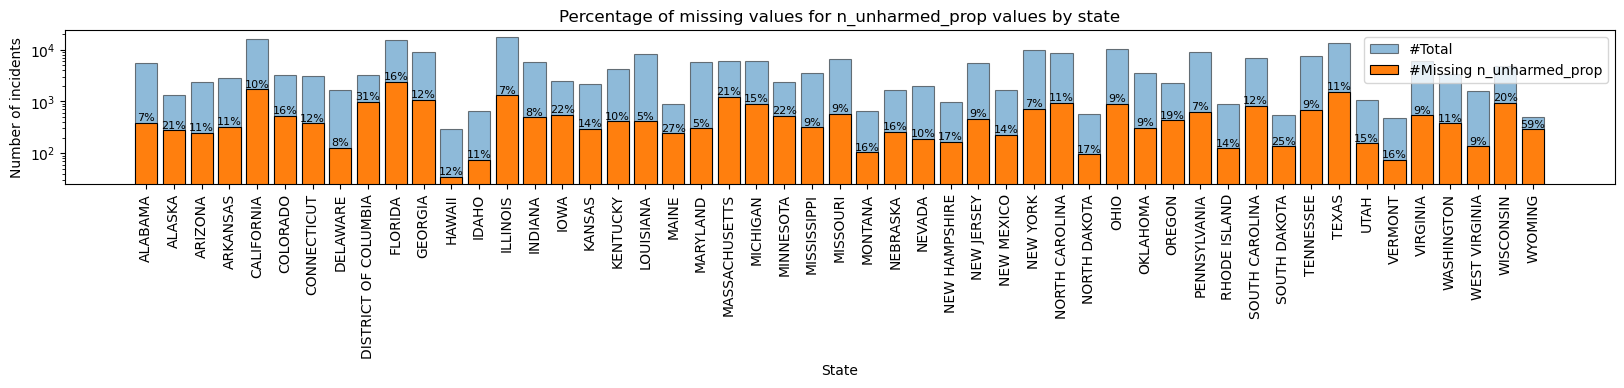

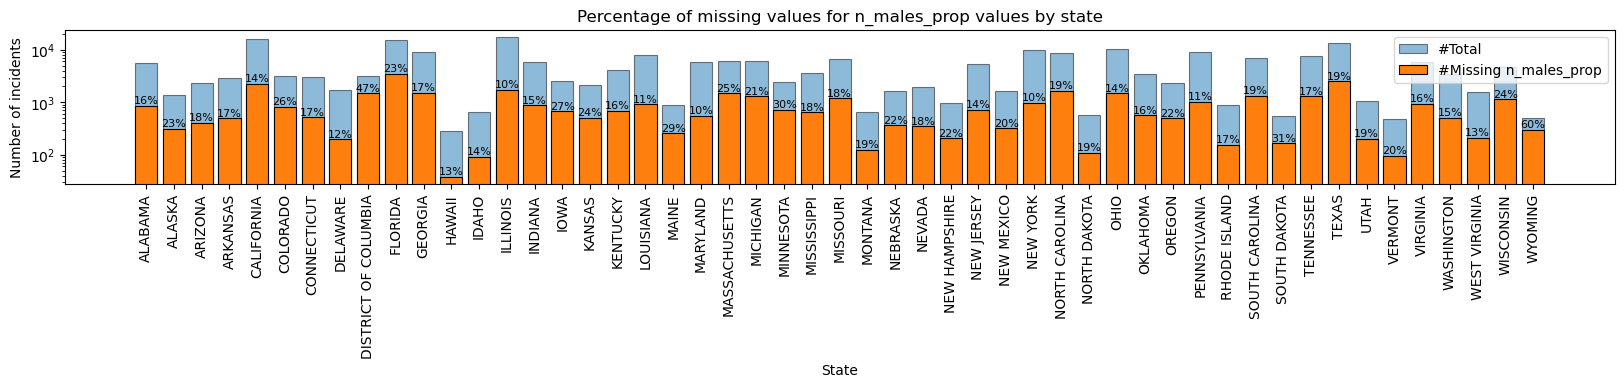

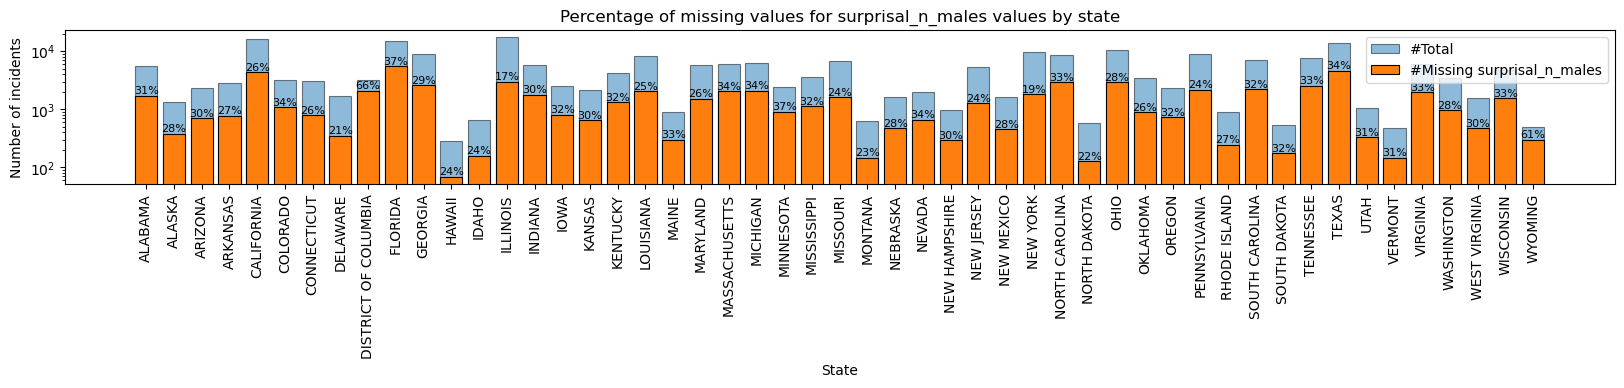

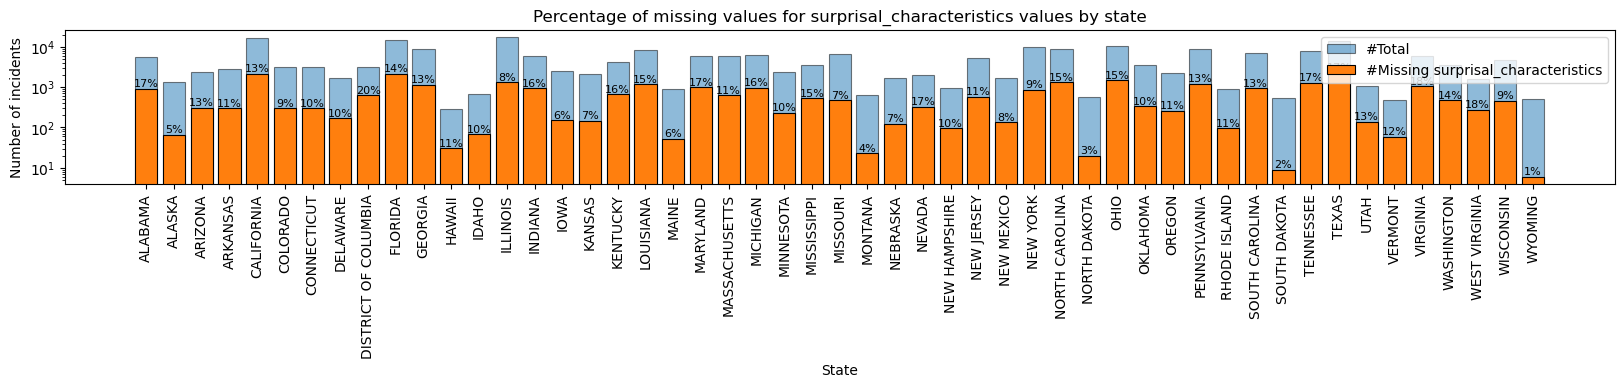

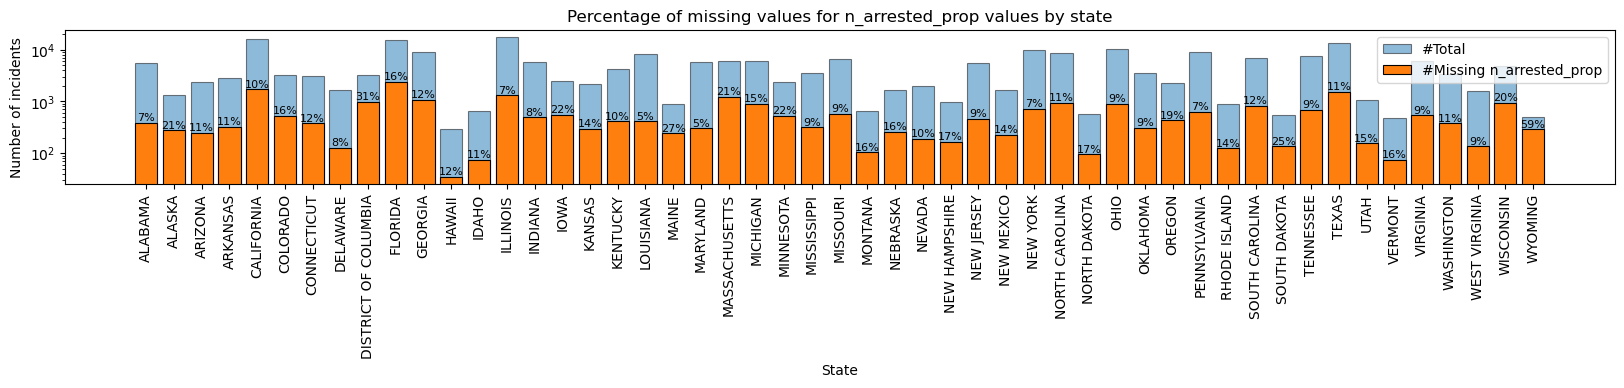

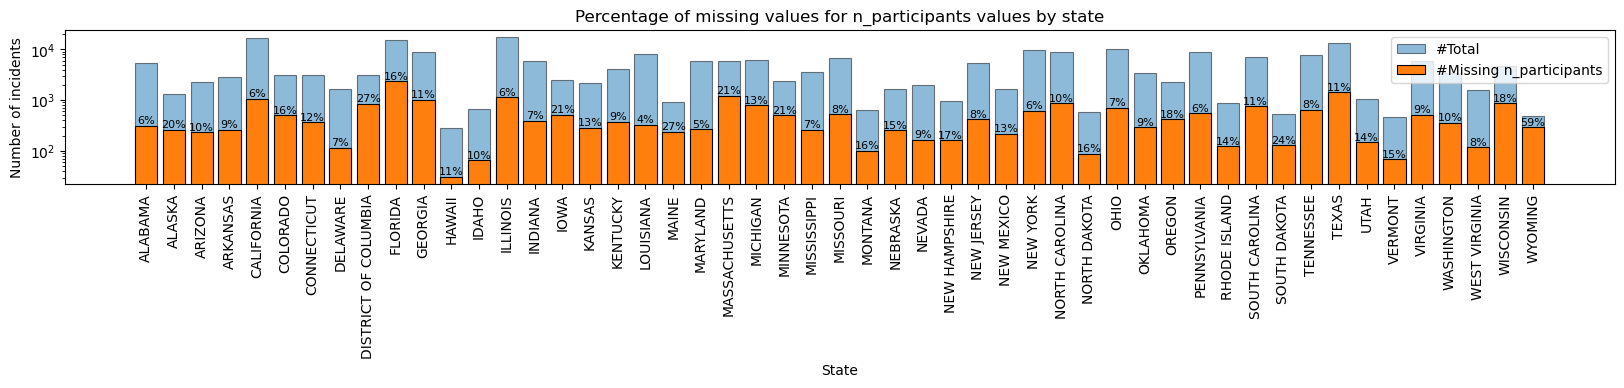

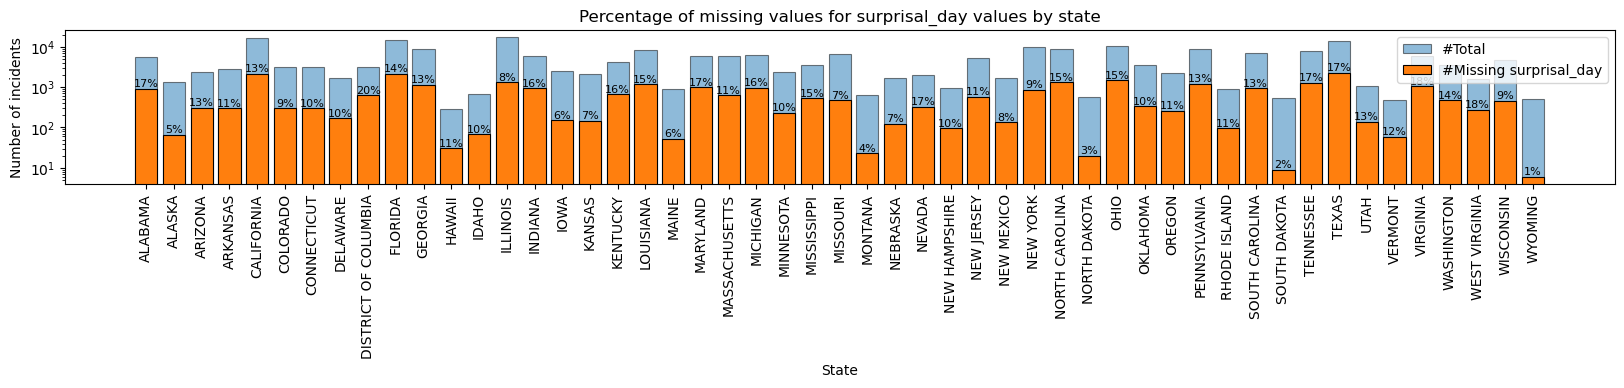

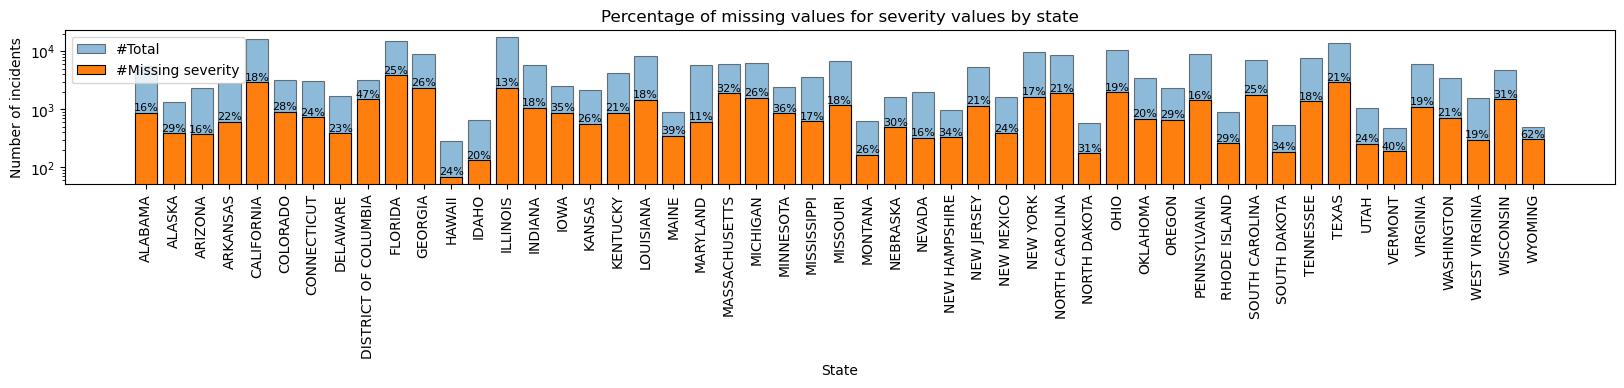

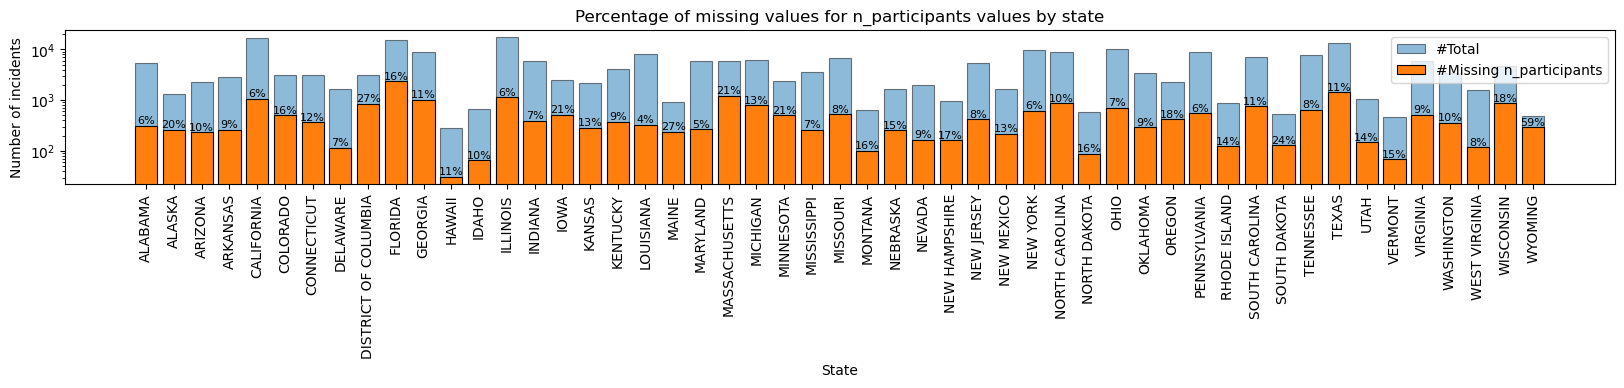

In [16]:
from plot_utils import plot_missing_values_for_state

for attribute in labels_list:
    plot_missing_values_for_state(df=incidents_df, attribute=attribute)

The observations that can be made are similar to those from before; there is a noticeable higher number of missing values for features related to age. Illinois and California appear to be among the states with lower percentages of missing values.

Finally, we printed the number of entries containing all non-null values for the columns listed in the following list.

In [17]:
columns = [
    'lat_proj', 'lon_proj', 'location_imp', 'surprisal_address_type', 'age_range', 'avg_age',
    'surprisal_min_age', 'n_child_prop', 'n_teen_prop', 'surprisal_age_groups', 'n_killed_prop',
    'n_injured_prop', 'surprisal_n_injured', 'n_unharmed_prop', 'n_males_prop',
    'surprisal_n_males', 'surprisal_characteristics', 'n_arrested_prop', 'n_participants',
    'surprisal_day', 'severity'
]

In [18]:
incidents_df[incidents_df['state']=='CALIFORNIA'][columns].dropna().shape[0]

8034

In [19]:
incidents_df[incidents_df['state']=='ILLINOIS'][columns].dropna().shape[0]

12905

In [20]:
incidents_df[incidents_df['state']=='TEXAS'][columns].dropna().shape[0]

6020

In [21]:
incidents_df[incidents_df['state']=='FLORIDA'][columns].dropna().shape[0]

6979

Given that Illinois has the highest number of non-null features, we have decided to continue the analysis by focusing on the data related to this state.

## Illinois Data

Below, we printed the distribution of data related to the state of Illinois, divided by features (in orange), and compared them with the distribution of data for the entire dataset for the same features (in blue).

In [22]:
ind_names_discrete_list = [
    'age_range',
    'avg_age',
    'n_participants',
    ]
ind_names_continuous_list = [indice for indice in columns if indice not in ind_names_discrete_list]

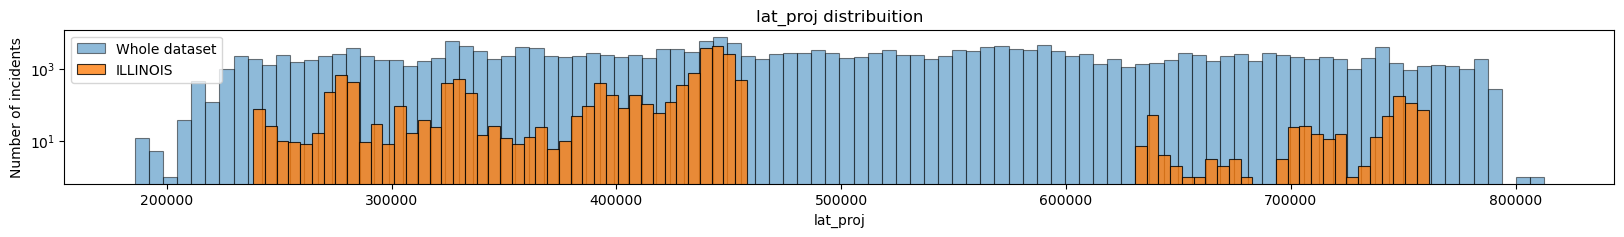

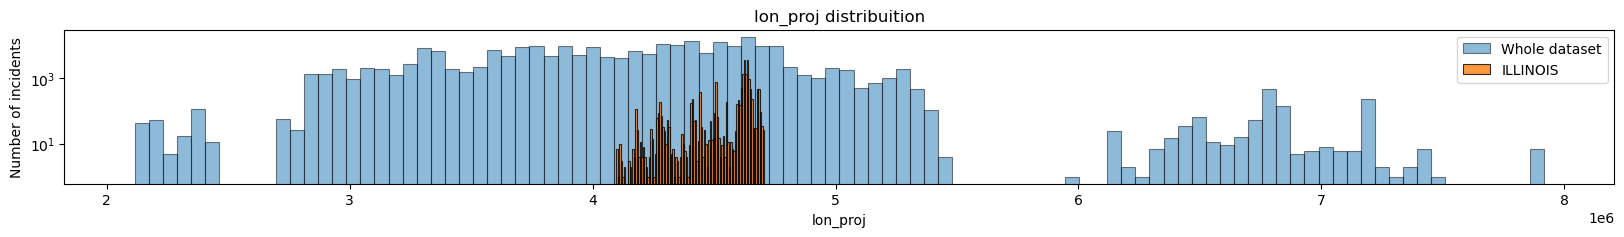

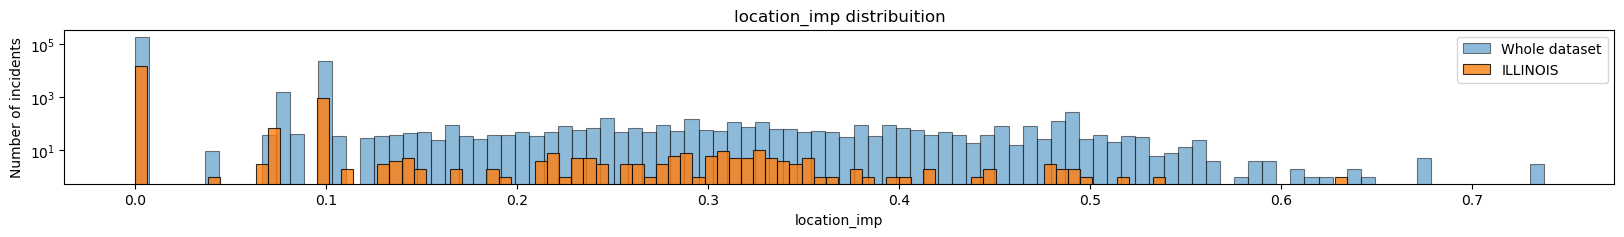

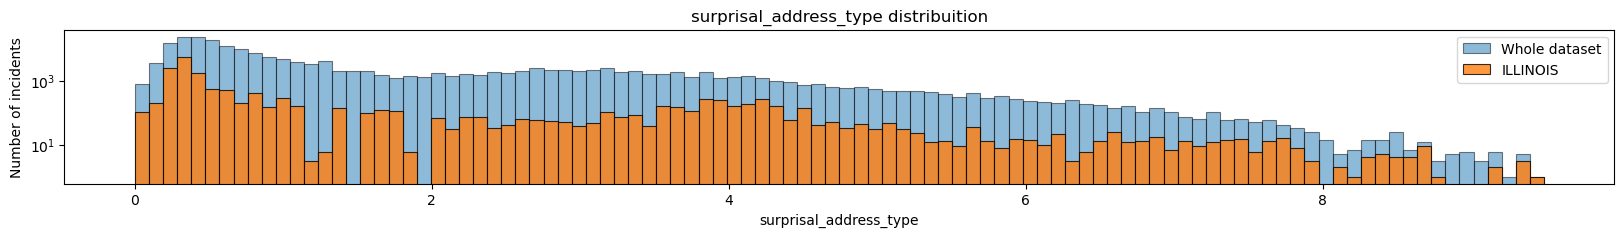

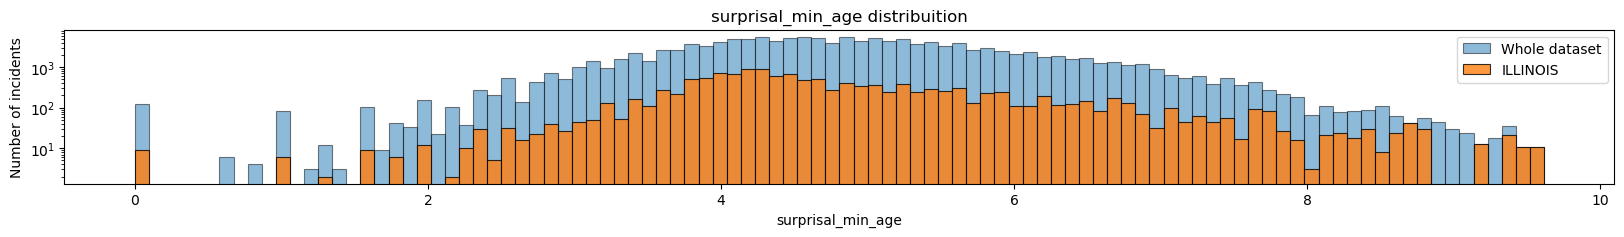

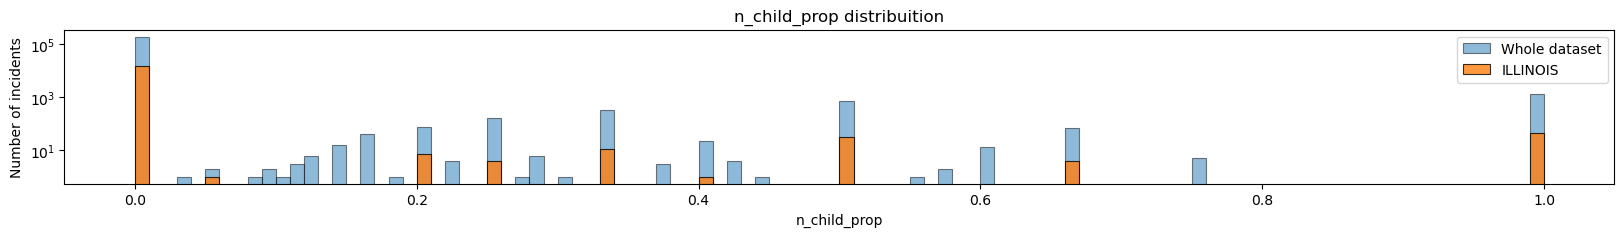

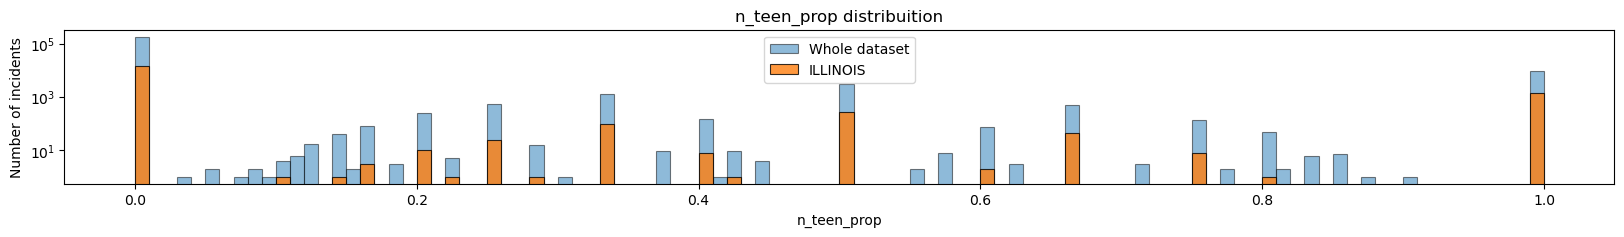

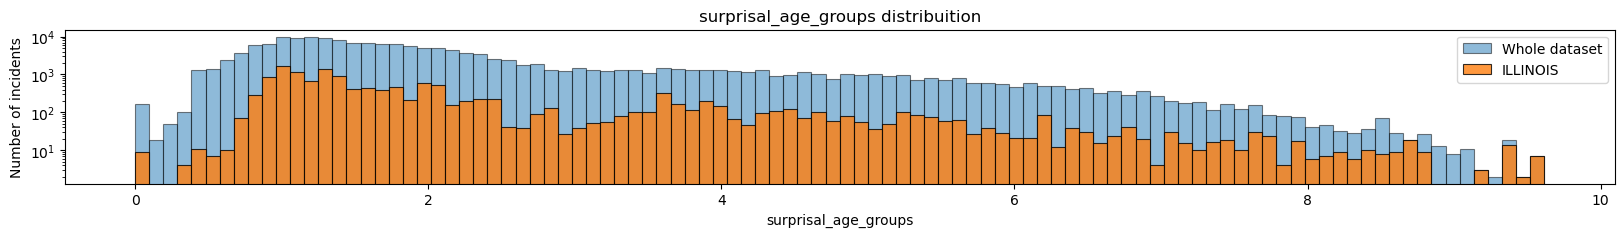

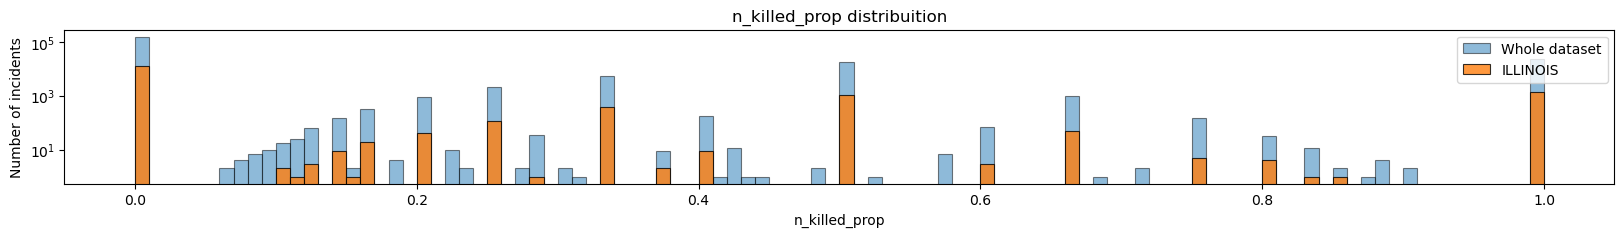

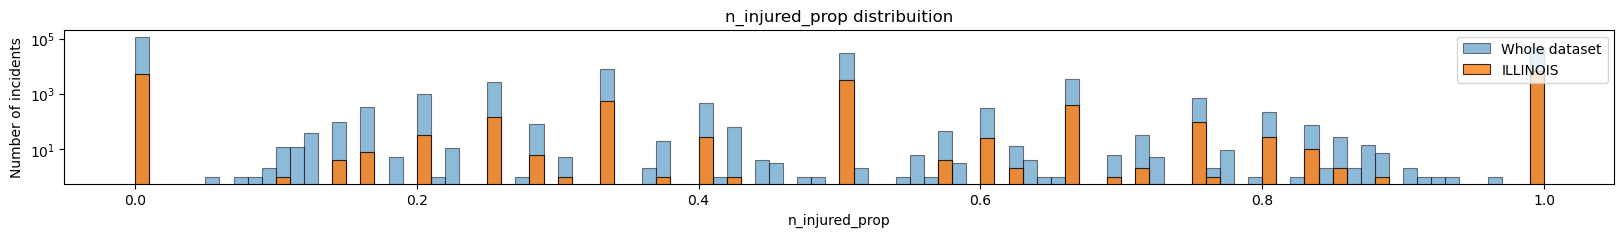

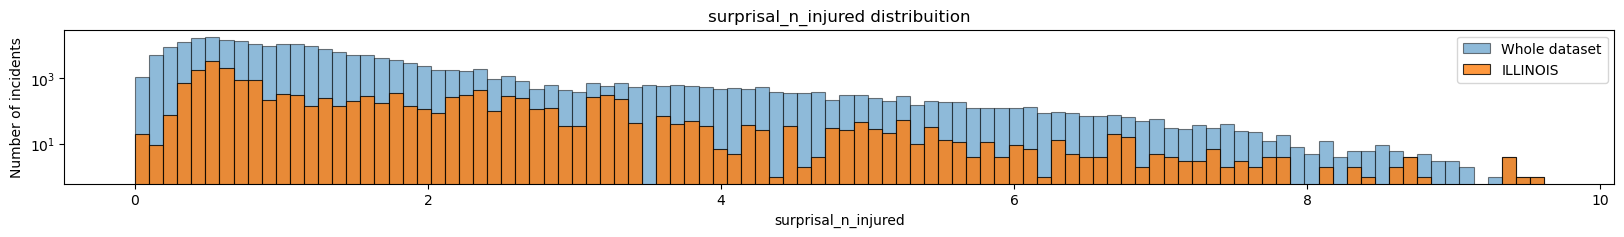

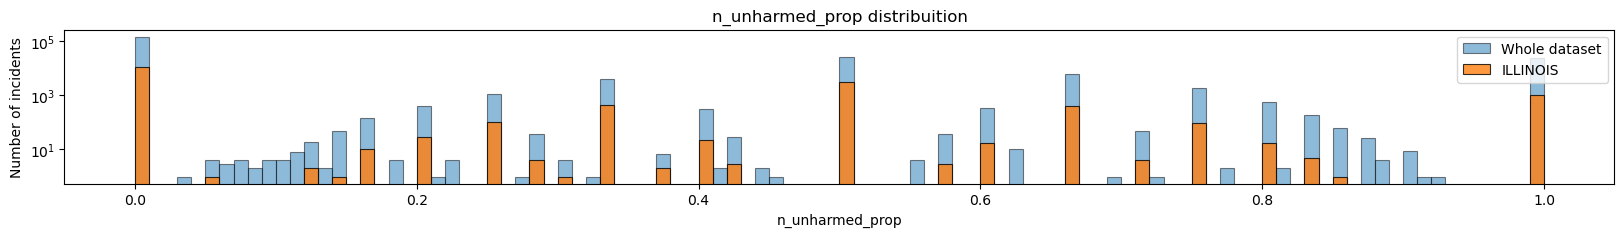

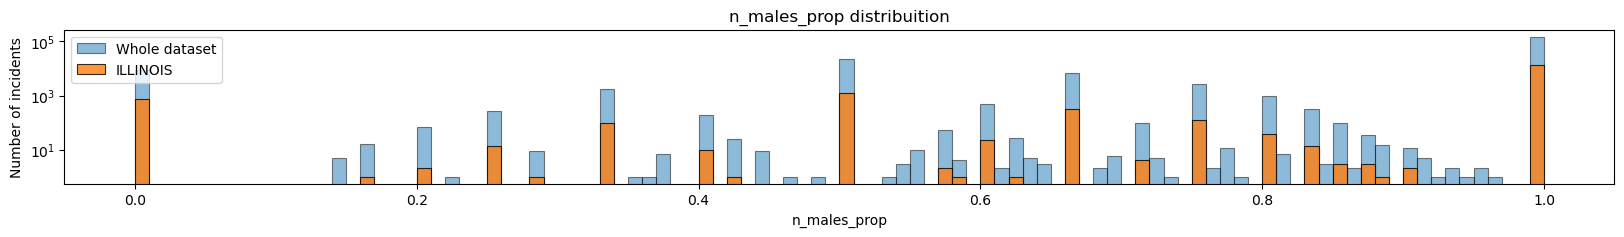

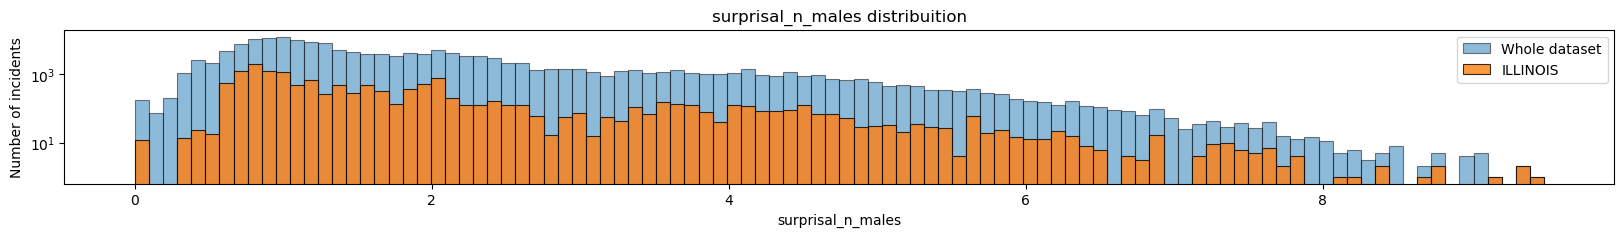

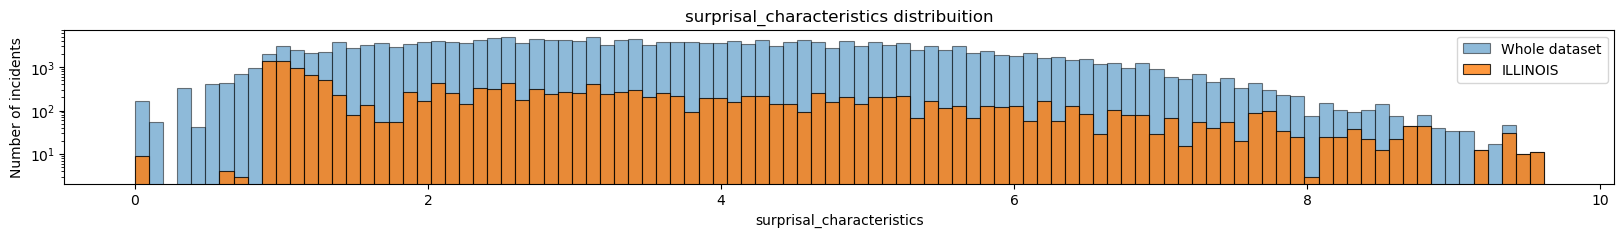

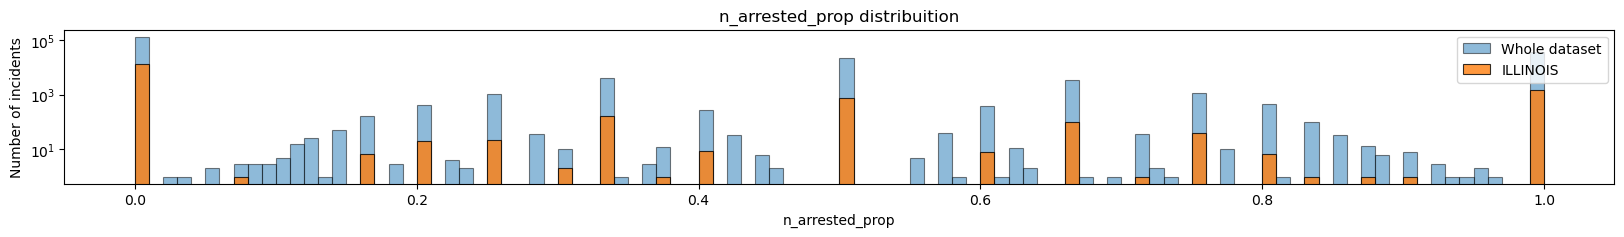

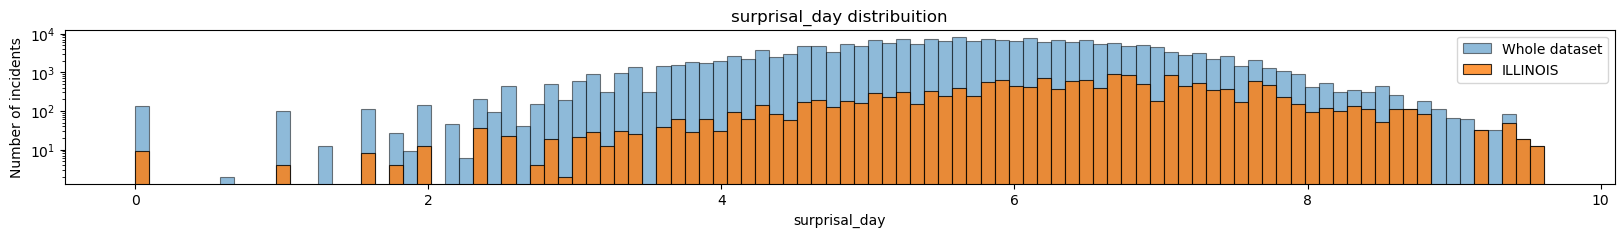

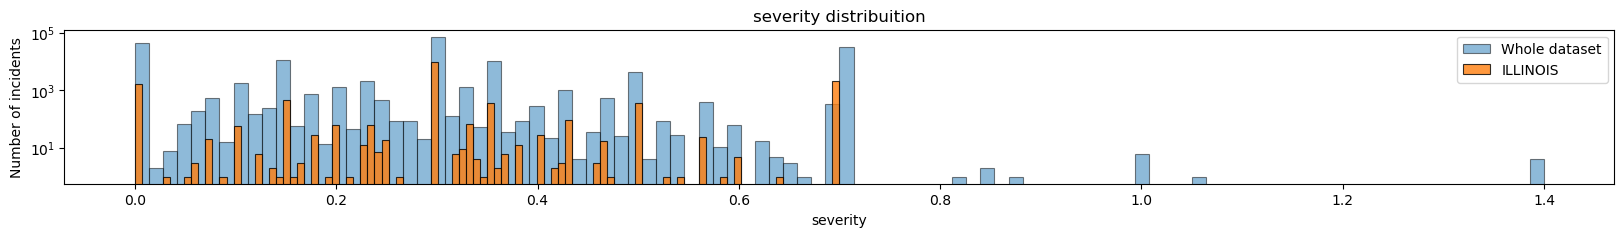

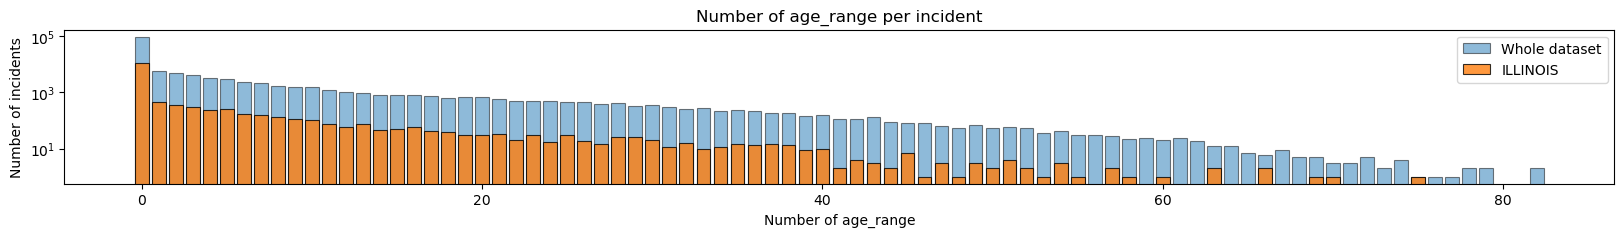

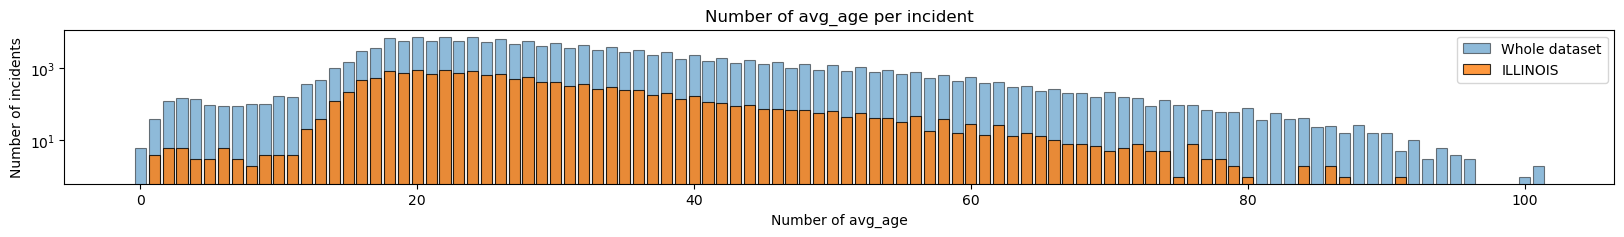

In [23]:
from plot_utils import continuous_attribute_distribuition_plot, discrete_attribute_distribuition_plot

for attribute in ind_names_continuous_list:
    continuous_attribute_distribuition_plot(df=incidents_df, attribute=attribute, state='ILLINOIS')
for attribute in ['age_range','avg_age',]:
    discrete_attribute_distribuition_plot(df=incidents_df, attribute=attribute, state='ILLINOIS')

With the exception of latitude and longitude projections, which are naturally different for each state, we can observe that the distribution of data for the state of Illinois is very similar to that of the entire dataset for all features.

Below, the mean, standard deviation, minimum, maximum, and quantiles for the selected features have been printed for both the Illinois-specific data and the entire dataset.

To make the data more easily interpretable, boxplots representing the distributions of some selected features have been printed, comparing data related to the state of Illinois and the entire dataset.

In [24]:
incidents_df[incidents_df['state']=='ILLINOIS'][columns].describe()

lat_proj      lon_proj  location_imp  surprisal_address_type  \
count   16784.000000  1.678400e+04  1.678400e+04            16159.000000   
mean   426162.407503  4.592989e+06  8.529419e-03                1.238483   
std     80019.949284  9.900526e+04  3.673008e-02                1.625750   
min    238403.765917  4.096726e+06  1.000000e-07               -0.000000   
25%    426864.063188  4.615430e+06  1.000000e-07                0.312384   
50%    441596.300340  4.626300e+06  1.000000e-05                0.368151   
75%    446839.741820  4.637271e+06  1.000000e-05                1.084064   
max    761313.507875  4.706920e+06  6.346983e-01                9.489848   

          age_range       avg_age  surprisal_min_age  n_child_prop  \
count  14189.000000  14189.000000       13548.000000  15727.000000   
mean       2.100994     27.073437           4.850208      0.004463   
std        6.207087     10.094456           1.166254      0.060141   
min        0.000000      1.000000          -0.000000      0.000000   
25%        0.000000     20.000000           4.100264      0.000000   
50%        0.000000     24.000000           4.518729      0.000000   
75%        0.000000     31.000000           5.452859      0.000000   
max       75.000000     91.000000           9.614710      1.000000   

        n_teen_prop  surprisal_age_groups  ...  n_injured_prop  \
count  15727.000000          14576.000000  ...    16418.000000   
mean       0.099338              2.204925  ...        0.535193   
std        0.287095              1.604505  ...        0.430183   
min        0.000000             -0.000000  ...        0.000000   
25%        0.000000              1.122857  ...        0.000000   
50%        0.000000              1.511899  ...        0.500000   
75%        0.000000              2.600904  ...        1.000000   
max        1.000000              9.614710  ...        1.000000   

       surprisal_n_injured  n_unharmed_prop  n_males_prop  surprisal_n_males  \
count         16230.000000     16241.000000  15828.000000       14582.000000   
mean              1.280440         0.190379      0.898652           1.721483   
std               1.191512         0.304268      0.250896           1.285674   
min              -0.000000         0.000000      0.000000          -0.000000   
25%               0.536053         0.000000      1.000000           0.820179   
50%               0.682995         0.000000      1.000000           1.152003   
75%               1.788496         0.500000      1.000000           2.038637   
max               9.614710         1.000000      1.000000           9.489848   

       surprisal_characteristics  n_arrested_prop  n_participants  \
count               16230.000000     16241.000000    16418.000000   
mean                    3.120221         0.127019        1.691497   
std                     1.998888         0.305846        0.968796   
min                    -0.000000         0.000000        1.000000   
25%                     1.237183         0.000000        1.000000   
50%                     2.744345         0.000000        1.000000   
75%                     4.459432         0.000000        2.000000   
max                     9.614710         1.000000       20.000000   

       surprisal_day      severity  
count   16230.000000  15228.000000  
mean        6.421032      0.320890  
std         1.153642      0.182524  
min        -0.000000      0.000000  
25%         5.781360      0.300000  
50%         6.507795      0.300000  
75%         7.167920      0.300000  
max         9.614710      0.700000  

[8 rows x 21 columns]

In [25]:
incidents_df[columns].describe()

lat_proj      lon_proj  location_imp  surprisal_address_type  \
count  226585.000000  2.265850e+05  2.265850e+05           204054.000000   
mean   490770.366364  4.156603e+06  1.606031e-02                1.435818   
std    147911.945695  5.648101e+05  5.269348e-02                1.480367   
min    185788.738218  2.115487e+06  1.000000e-07               -0.000000   
25%    366224.725054  3.754090e+06  1.000000e-07                0.407175   
50%    479287.965180  4.274260e+06  1.000000e-05                0.704015   
75%    596851.904017  4.588523e+06  1.000000e-05                2.247928   
max    812648.538588  7.916594e+06  7.378515e-01                9.489848   

           age_range        avg_age  surprisal_min_age   n_child_prop  \
count  144855.000000  144855.000000      138954.000000  197948.000000   
mean        3.502924      30.180063           4.899098       0.009703   
std         8.200518      12.383141           1.100406       0.088879   
min         0.000000       0.000000          -0.000000       0.000000   
25%         0.000000      21.000000           4.169925       0.000000   
50%         0.000000      27.000000           4.807355       0.000000   
75%         3.000000      36.000000           5.554589       0.000000   
max        82.000000     101.000000           9.614710       1.000000   

         n_teen_prop  surprisal_age_groups  ...  n_injured_prop  \
count  197948.000000         172004.000000  ...   214751.000000   
mean        0.061359              2.234827  ...        0.337210   
std         0.224411              1.530011  ...        0.415972   
min         0.000000             -0.000000  ...        0.000000   
25%         0.000000              1.176878  ...        0.000000   
50%         0.000000              1.700440  ...        0.000000   
75%         0.000000              2.719892  ...        0.666667   
max         1.000000              9.614710  ...        1.000000   

       surprisal_n_injured  n_unharmed_prop   n_males_prop  surprisal_n_males  \
count        208710.000000    211988.000000  198137.000000      169419.000000   
mean              1.156242         0.214454       0.871090           1.841888   
std               1.037708         0.349775       0.261101           1.271162   
min              -0.000000         0.000000       0.000000          -0.000000   
25%               0.516398         0.000000       1.000000           0.951090   
50%               0.868440         0.000000       1.000000           1.362570   
75%               1.374396         0.500000       1.000000           2.306661   
max               9.614710         1.000000       1.000000           9.489848   

       surprisal_characteristics  n_arrested_prop  n_participants  \
count              208710.000000    211988.000000   214751.000000   
mean                    3.677301         0.262360        1.826520   
std                     1.681165         0.392576        1.185155   
min                    -0.000000         0.000000        1.000000   
25%                     2.353637         0.000000        1.000000   
50%                     3.554589         0.000000        2.000000   
75%                     4.906891         0.500000        2.000000   
max                     9.614710         1.000000      103.000000   

       surprisal_day       severity  
count  208710.000000  187999.000000  
mean        5.715016       0.289957  
std         1.133626       0.228916  
min        -0.000000       0.000000  
25%         5.000000       0.100000  
50%         5.754888       0.300000  
75%         6.483816       0.350000  
max         9.614710       1.400000  

[8 rows x 21 columns]

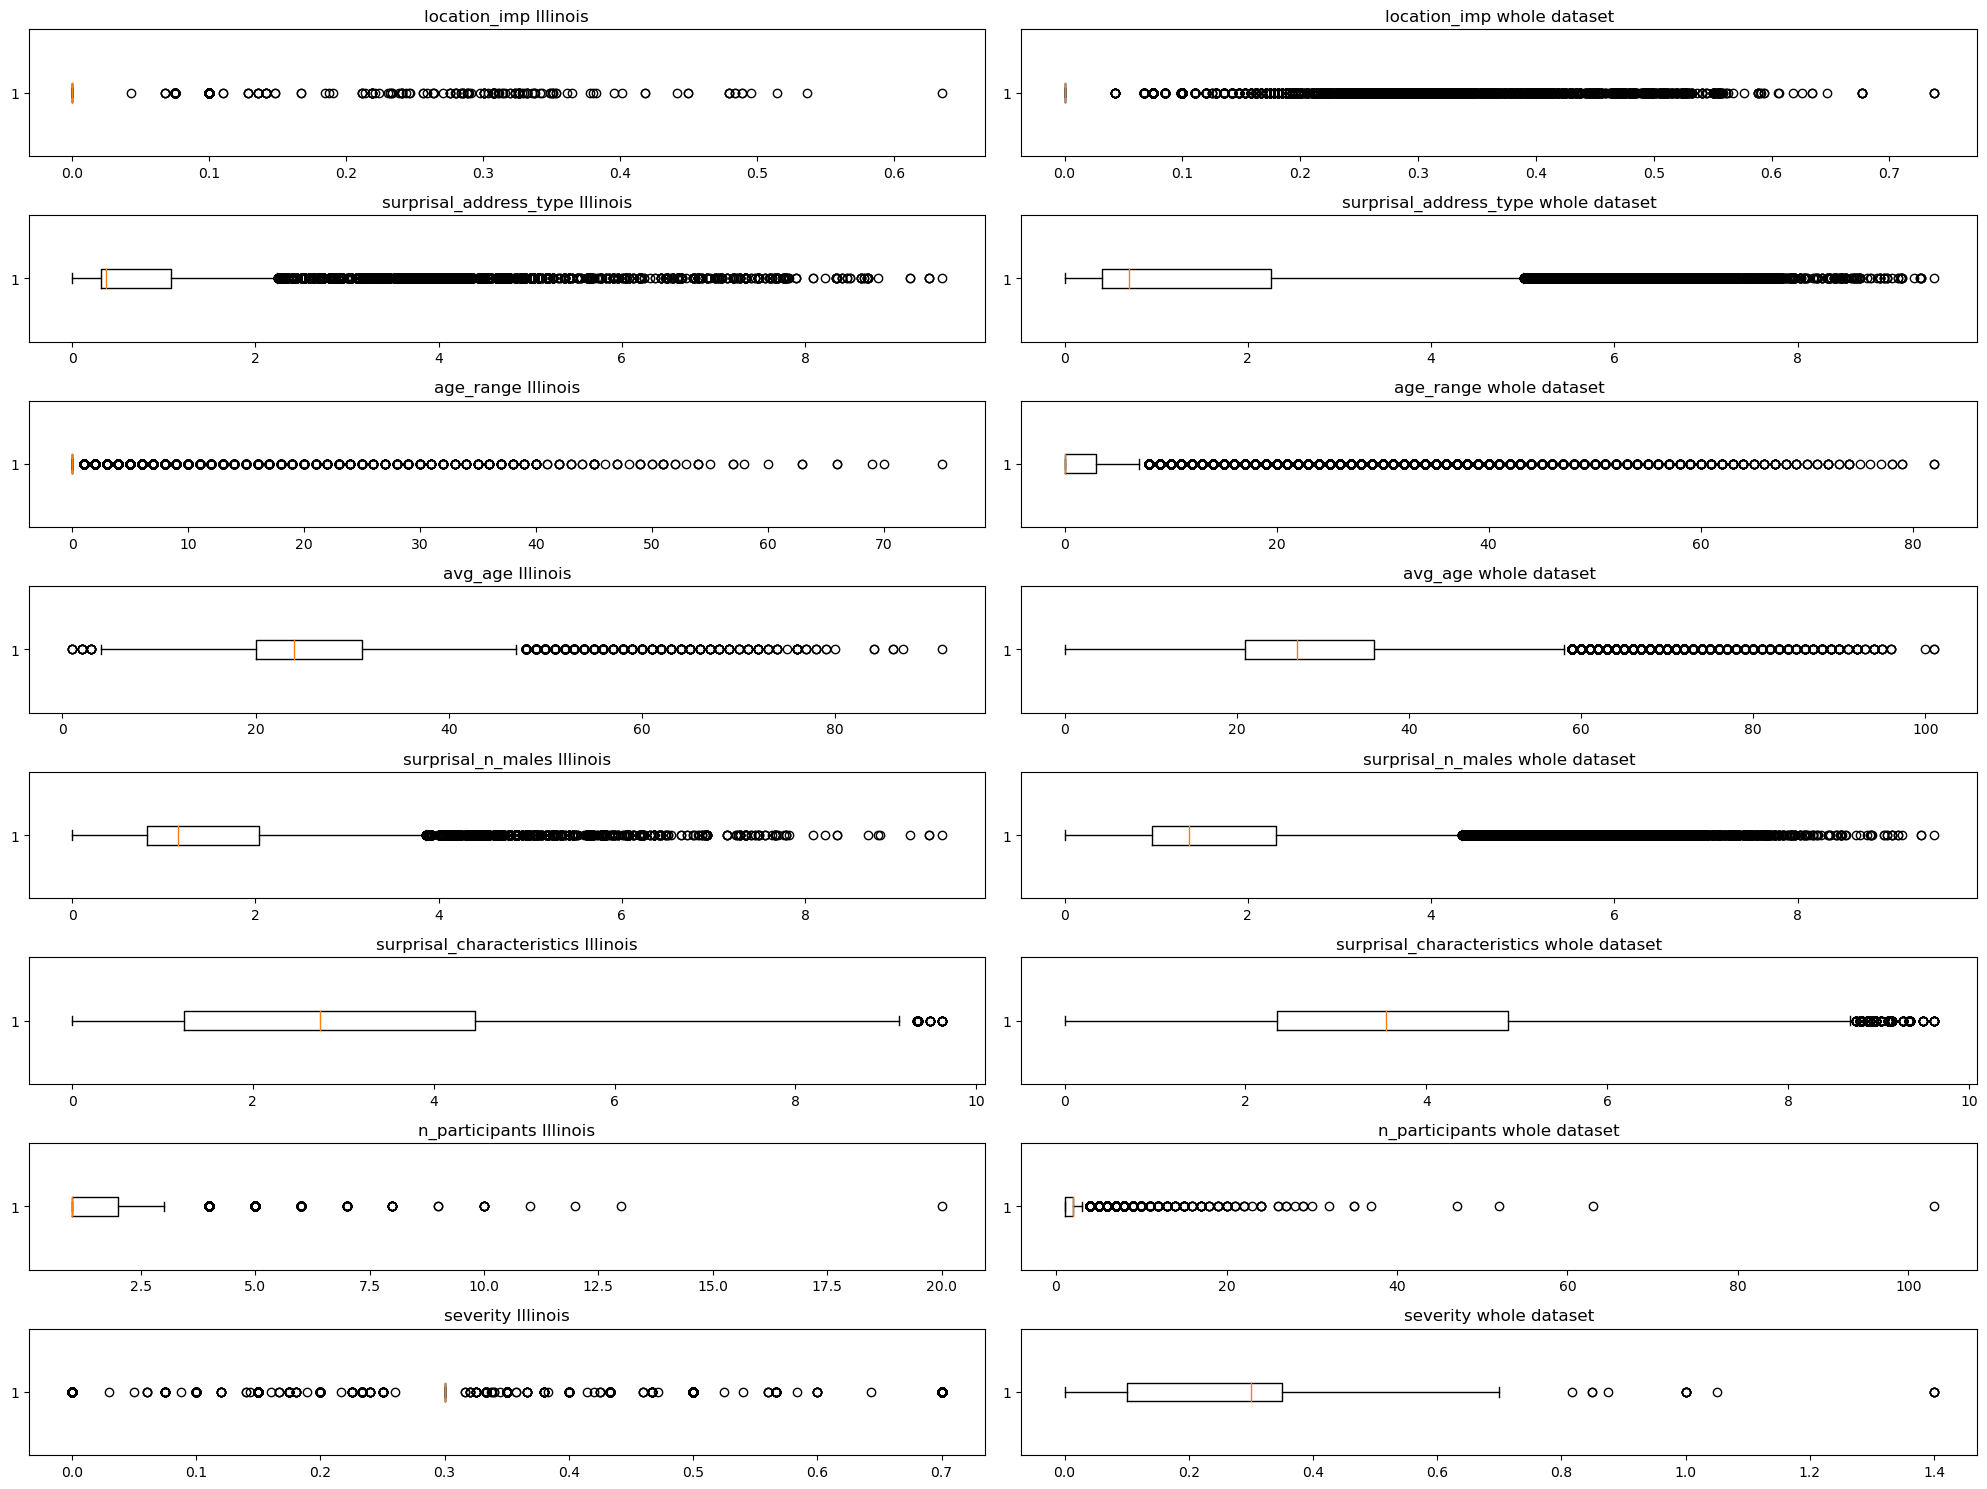

In [26]:
attributes = ['location_imp', 'surprisal_address_type', 'age_range', 'avg_age',
    'surprisal_n_males', 'surprisal_characteristics', 'n_participants', 'severity']
 
fig, ax = plt.subplots(int(np.ceil(len(attributes))), 2, figsize=(20, 15))
for i, attribute in enumerate(attributes):
    ax[i, 0].boxplot(incidents_df[incidents_df['state']=='ILLINOIS'][attribute].dropna(), vert=False)
    ax[i, 0].set_title(attribute+' Illinois')
    ax[i, 1].boxplot(incidents_df[attribute].dropna(), vert=False)
    ax[i, 1].set_title(attribute+' whole dataset')
fig.tight_layout()
plt.show()

We notice that the severity index shows a lower range of values for the state of Illinois (between 0 and 0.7) compared to the entire dataset (between 0 and 1.4), highlighting a significant number of outliers.

The maximum number of participants is 20, while in the dataset, incidents with a higher number of people (up to a maximum of 103) are present, although they are considered outliers. However, the mean is very similar between the data for Illinois and the entire dataset.

The average age in incidents that occurred in Illinois is lower (27 years) compared to the overall dataset average (30 years).

The index representing the surprisal of address types in incidents has a lower mean and a slightly wider standard deviation for Illinois compared to the total dataset (mean=1.24 and standard deviation=1.63 vs mean=1.44 and standard deviation=1.48).

For all other features, Illinois shows significant similarities with the entire population of the dataset.

In conclusion, the analysis highlights some notable differences in Illinois data compared to the entire dataset, particularly for the severity index and the maximum number of participants. However, for most features, Illinois behaves similarly to the rest of the population, indicating that it could be a valid representative for further analysis and clustering algorithms.

Note that in a preliminary analysis, similar tests were also conducted for data related to the state of California, and the observations are analogous. However, in the notebook, only the results related to the state of Illinois are reported to keep the notebook clean.

Below we have plotted boxplots for the indicators and numerical features related to the state of Illinois, including those already reported above. This provides an overview of the selectable indicators for clustering algorithms.

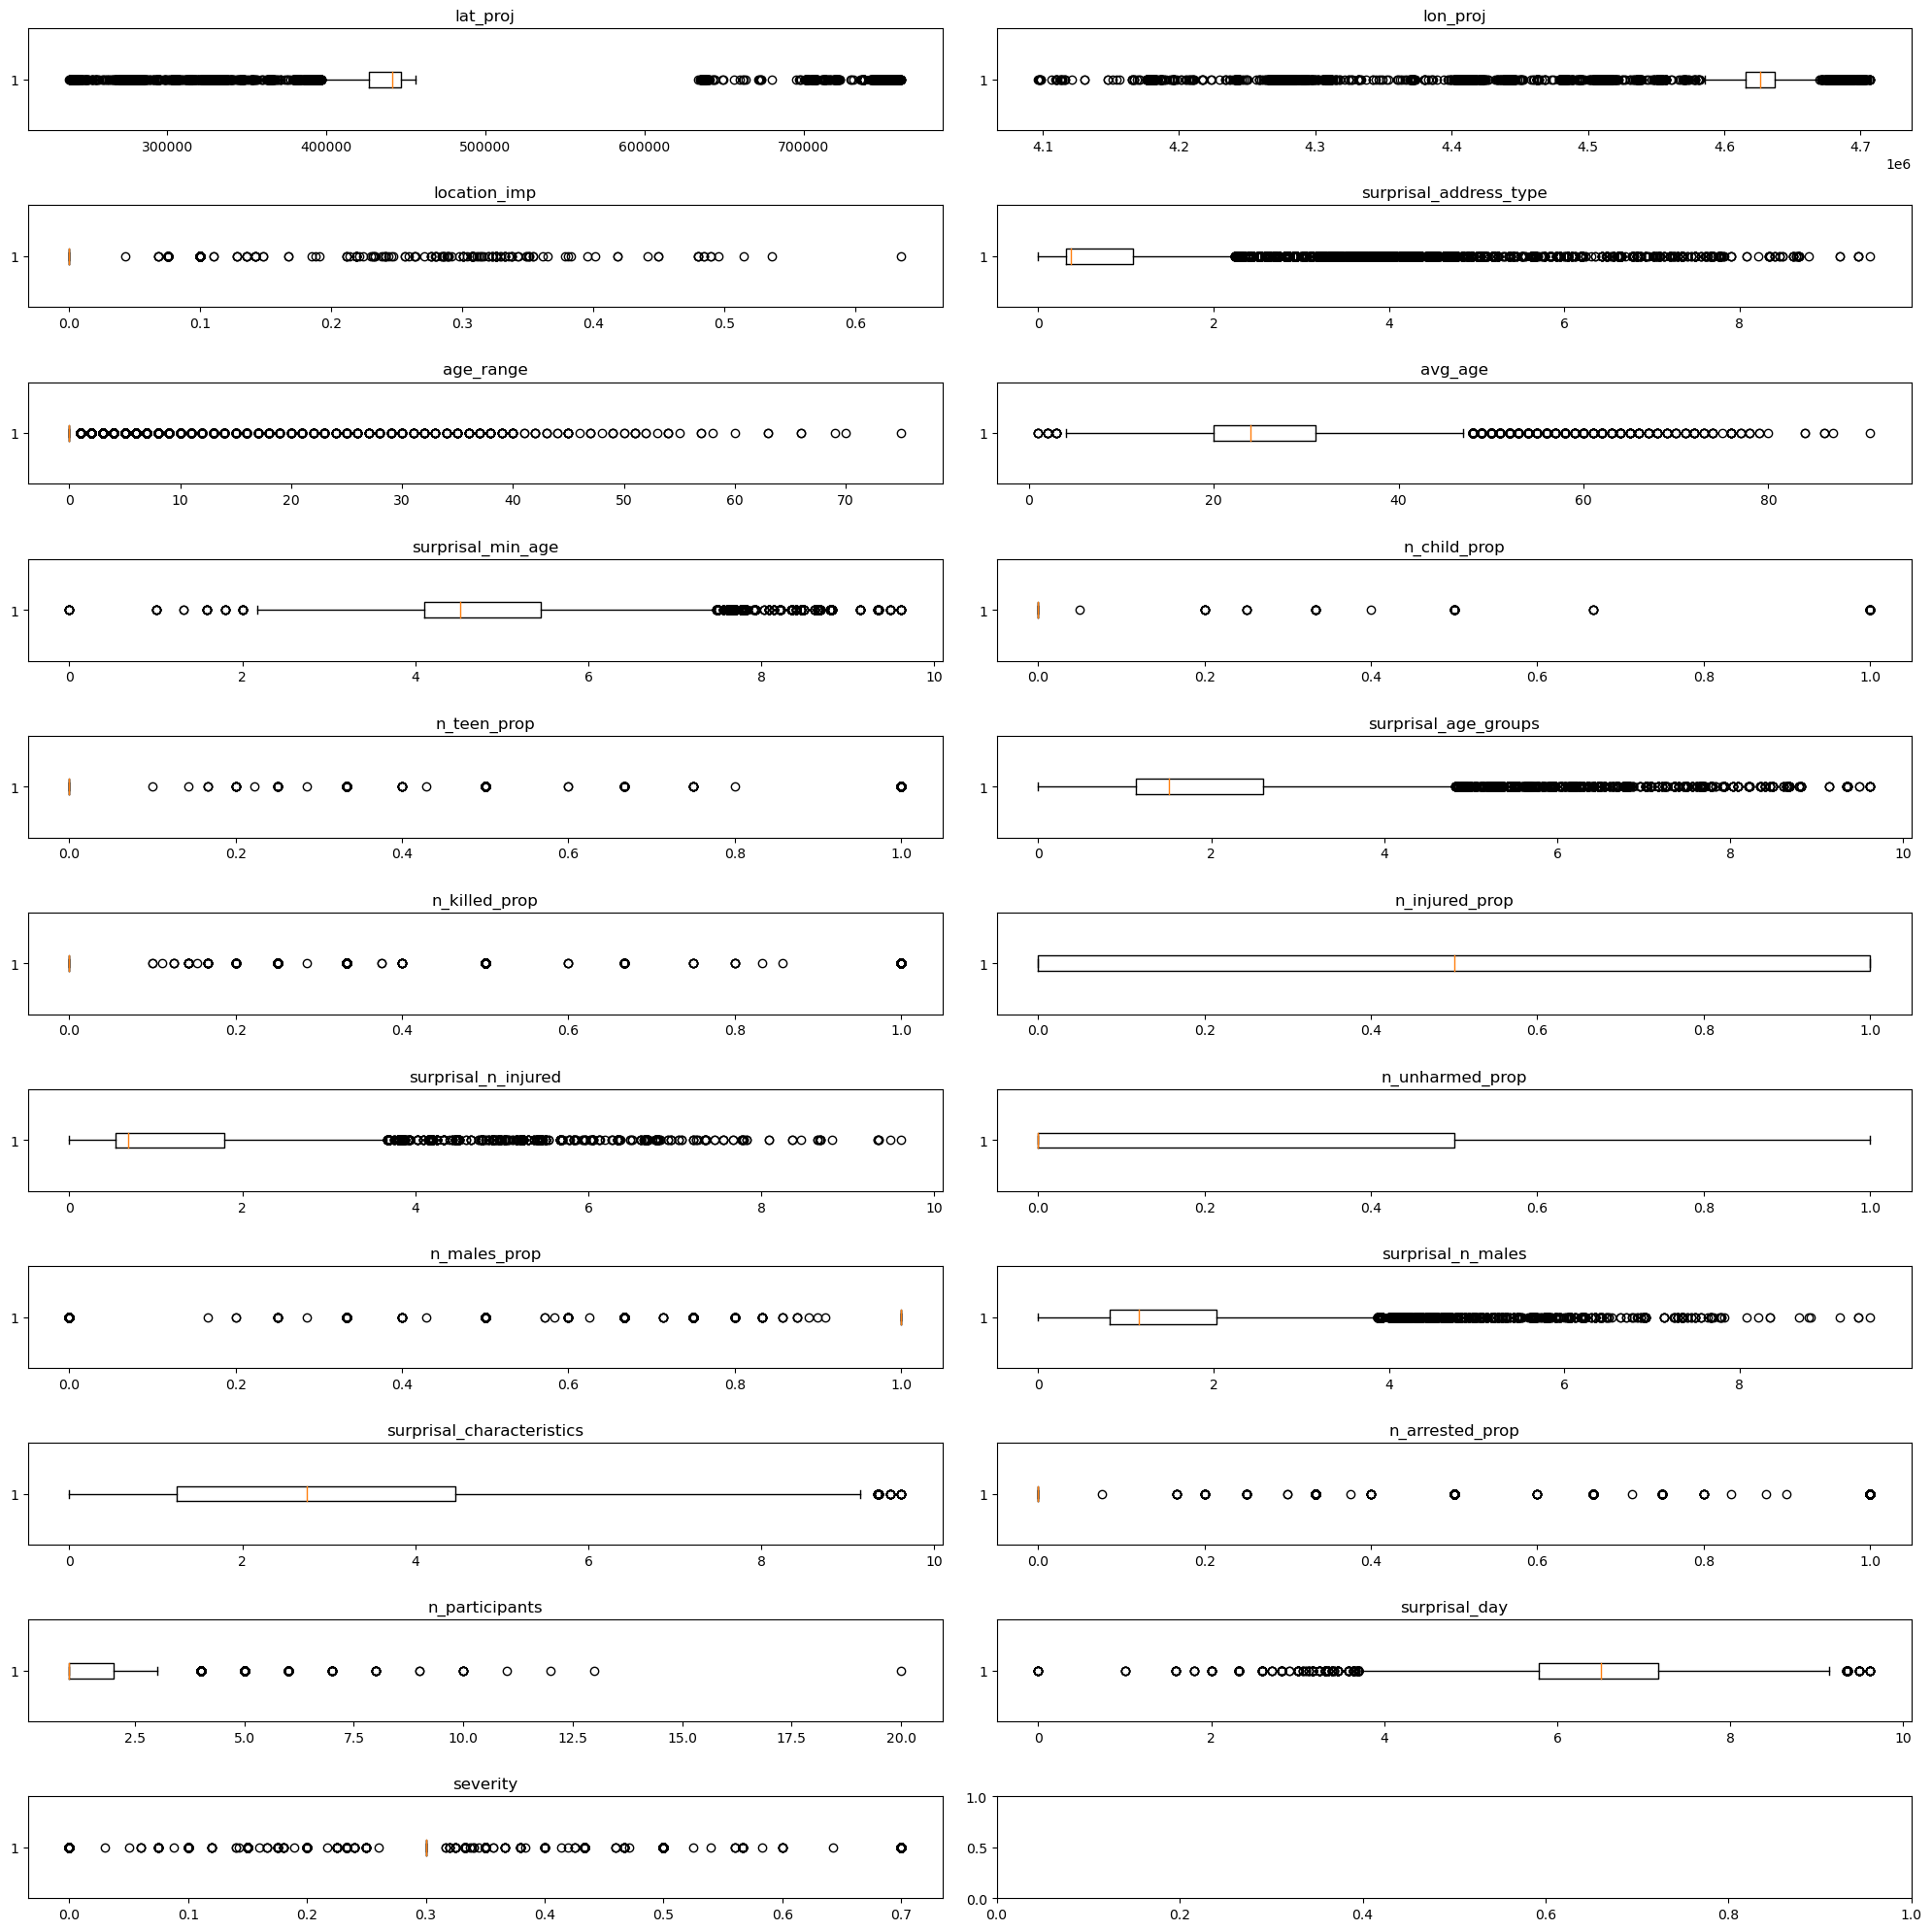

In [27]:
fig, ax = plt.subplots(int(np.ceil(len(columns)/2)), 2, figsize=(20, 20))
for i, attribute in enumerate(columns):
    ax[i//2, i%2].boxplot(incidents_df[incidents_df['state']=='ILLINOIS'][attribute].dropna(), vert=False)
    ax[i//2, i%2].set_title(attribute)
fig.tight_layout()
plt.show()

Finally, we reported the correlation matrix. We chose to use Kendall because it does not assume that the variables are normally distributed, and it is less affected by outliers compared to other correlation coefficients.

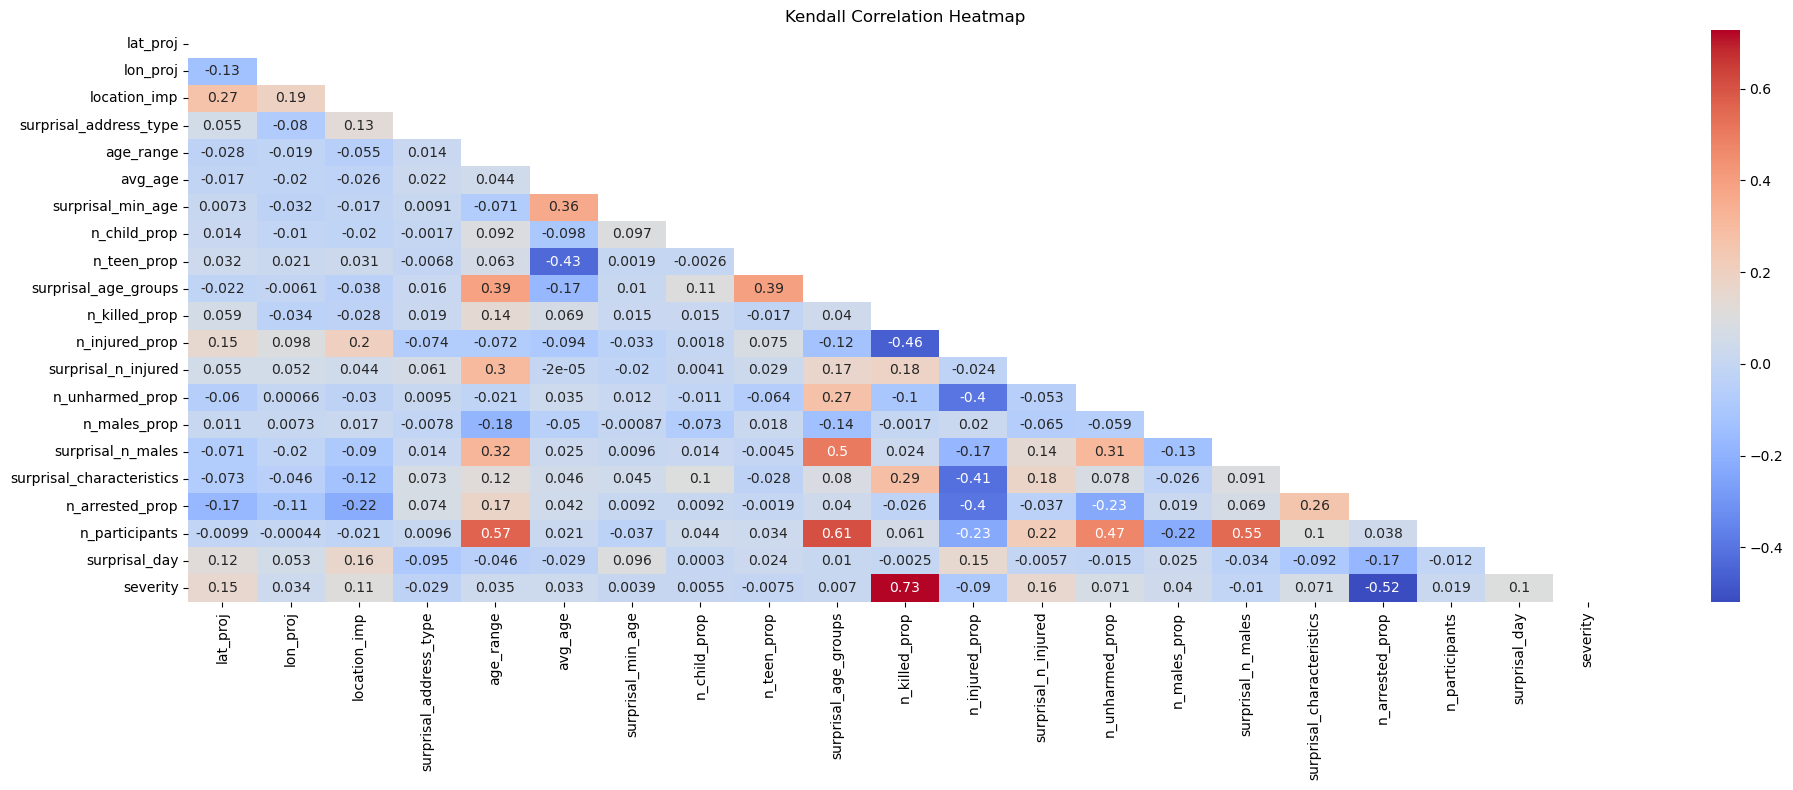

In [28]:
plt.figure(figsize=(20, 8))
sns.heatmap(incidents_df[incidents_df['state']=='ILLINOIS'][columns].corr('kendall'), 
    annot=True, cmap='coolwarm',
    mask=np.triu(np.ones_like(incidents_df[incidents_df['state'
    ]=='ILLINOIS'][columns].corr('kendall'), dtype=bool)))
plt.title(f'Kendall Correlation Heatmap')
plt.tight_layout()
plt.show()

From the matrix, we can observe that some features are correlated with each other, both positively and negatively. However, these are features or indicators with similar semantics, such as the number of children and the average age. These results will be taken into consideration for the attribute selection for clustering.

### Illinois Data Visualization

Below, we plot a map of Illinois divided by county to gain a better understanding of the state's geography and how it is distributed across counties. Additionally, we provide a visualization of the most frequent values for selected features in each county. This type of visualization can be helpful for a subsequent analysis of the results obtained from the clustering algorithms.

In [29]:
illinois_df = incidents_df[incidents_df['state']=='ILLINOIS'][columns].dropna()
illinois_df[['latitude', 'longitude', 'county', 'city']] = incidents_df.loc[illinois_df.index, [
    'latitude', 'longitude', 'county', 'city']]

illinois_df.info()
illinois_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12905 entries, 19 to 239353
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lat_proj                   12905 non-null  float64
 1   lon_proj                   12905 non-null  float64
 2   location_imp               12905 non-null  float64
 3   surprisal_address_type     12905 non-null  float64
 4   age_range                  12905 non-null  float64
 5   avg_age                    12905 non-null  float64
 6   surprisal_min_age          12905 non-null  float64
 7   n_child_prop               12905 non-null  float64
 8   n_teen_prop                12905 non-null  float64
 9   surprisal_age_groups       12905 non-null  float64
 10  n_killed_prop              12905 non-null  float64
 11  n_injured_prop             12905 non-null  float64
 12  surprisal_n_injured        12905 non-null  float64
 13  n_unharmed_prop            12905 non-null  f

lat_proj      lon_proj  location_imp  surprisal_address_type  \
19  437721.170765  4.637780e+06       0.00001                0.397964   
21  444652.109661  4.621057e+06       0.00001                0.344959   

    age_range  avg_age  surprisal_min_age  n_child_prop  n_teen_prop  \
19       42.0     36.0           4.122857           0.0     0.333333   
21        0.0     16.0           3.787903           0.0     1.000000   

    surprisal_age_groups  ...  surprisal_n_males  surprisal_characteristics  \
19              8.029747  ...           3.756729                   4.707819   
21              3.700440  ...           0.700440                   0.942413   

    n_arrested_prop  n_participants  surprisal_day  severity  latitude  \
19              0.0             3.0       7.614710  0.433333   41.8895   
21              0.0             1.0       5.787903  0.300000   41.7394   

    longitude       county     city  
19   -87.7507  Cook County  Chicago  
21   -87.6656  Cook County  Chicago  

[2 rows x 25 columns]

In [30]:
import geopandas as gpd

illinois_df['county'] = illinois_df['county'].str.replace(' County', '')
illinois_df['county'] = illinois_df['county'].str.replace('Saint Clair', 'St. Clair')
illinois_df['county'] = illinois_df['county'].str.replace('DeWitt', 'De Witt')

illinois_map = gpd.read_file('../cb_2018_us_county_500k')
illinois_merged = illinois_map.merge(illinois_df, left_on='NAME', right_on='county')
illinois_merged = illinois_merged[illinois_merged['STATEFP']=='17']

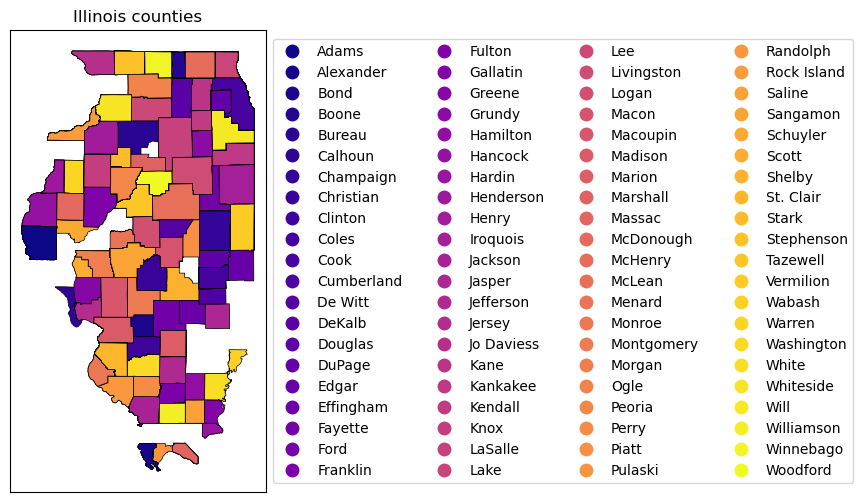

In [31]:
illinois_merged.plot(column='NAME', cmap='plasma', figsize=(20, 6), 
    legend=True, legend_kwds={'loc':'center left', 'bbox_to_anchor':(1, 0.5), 'ncol':4}, 
    edgecolor='black', linewidth=0.5)
plt.title('Illinois counties')
plt.xticks([])
plt.yticks([])
plt.show()

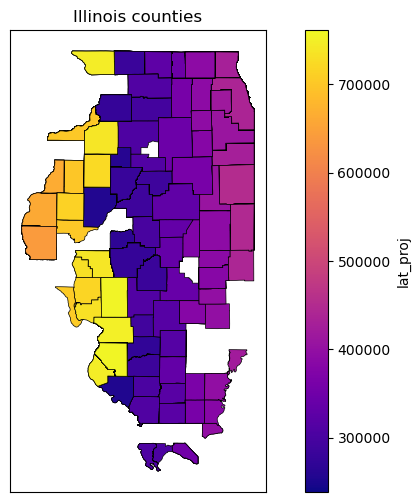

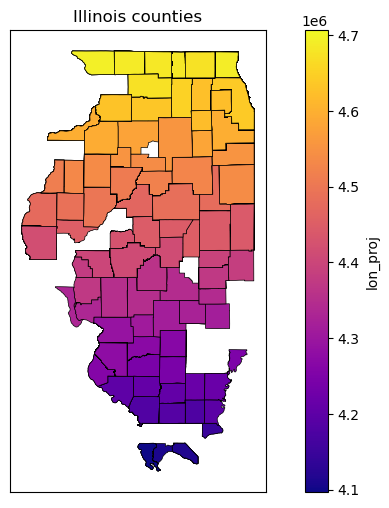

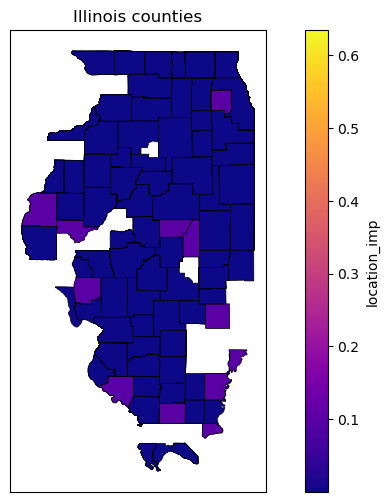

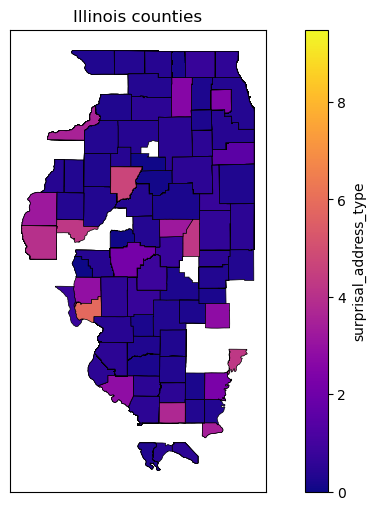

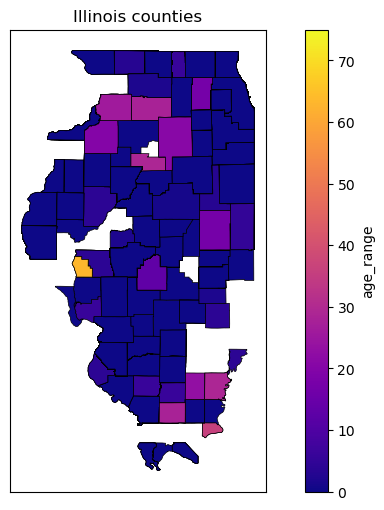

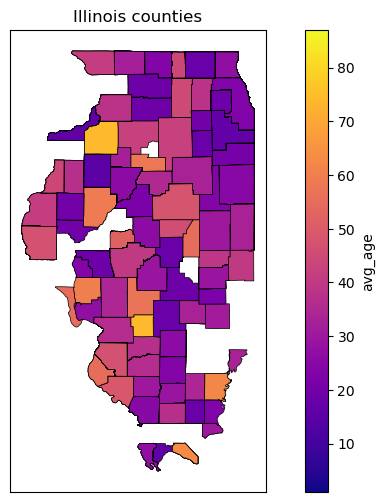

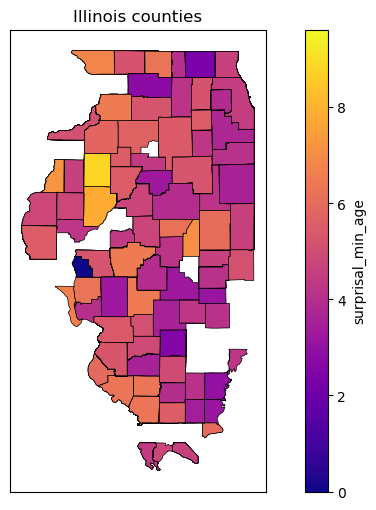

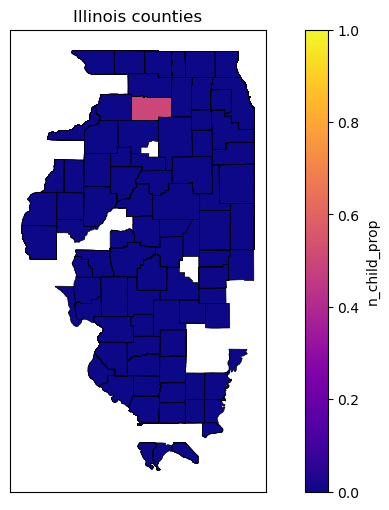

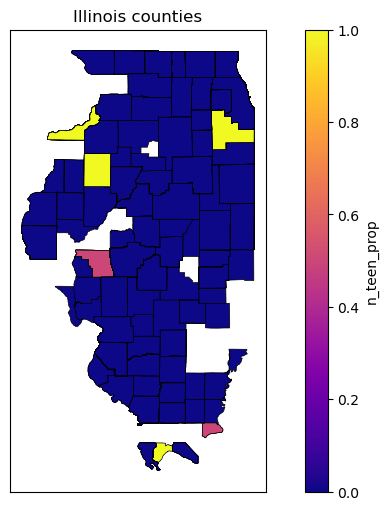

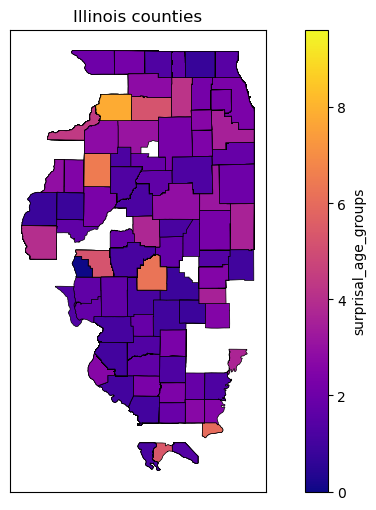

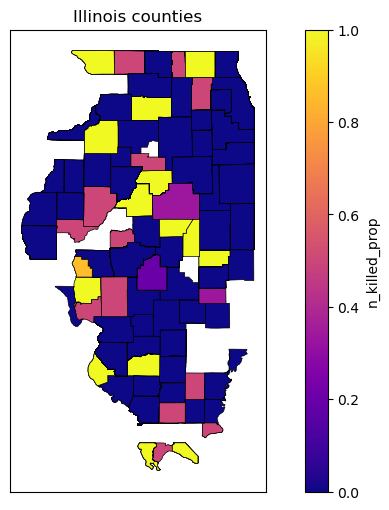

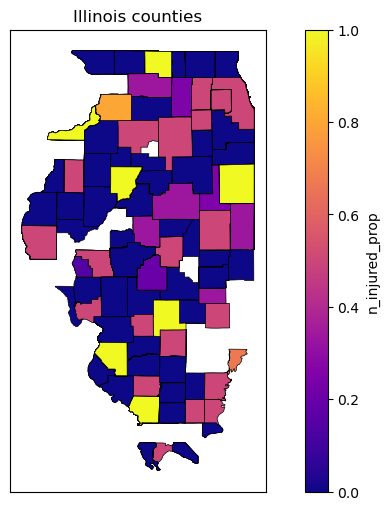

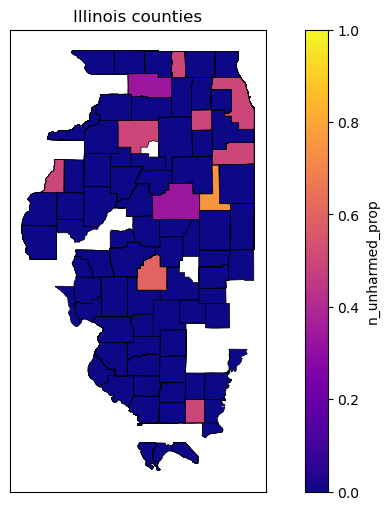

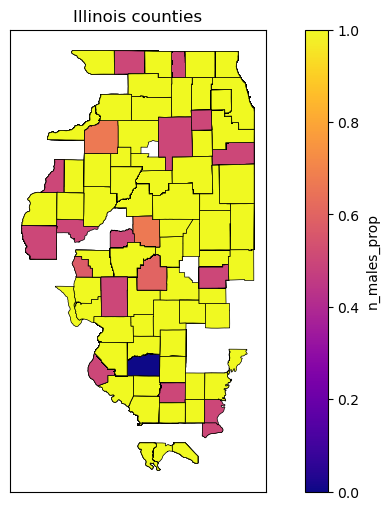

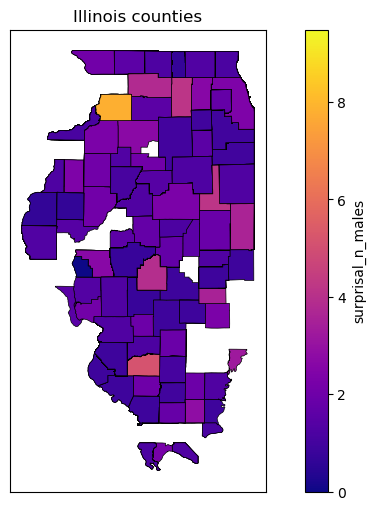

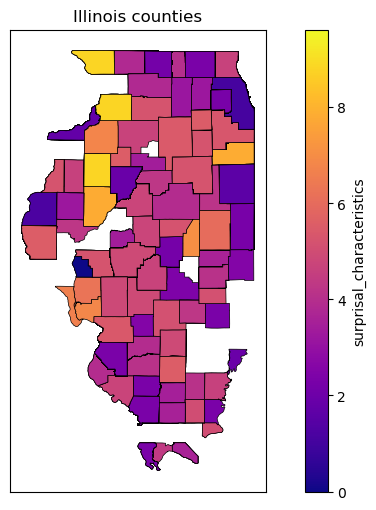

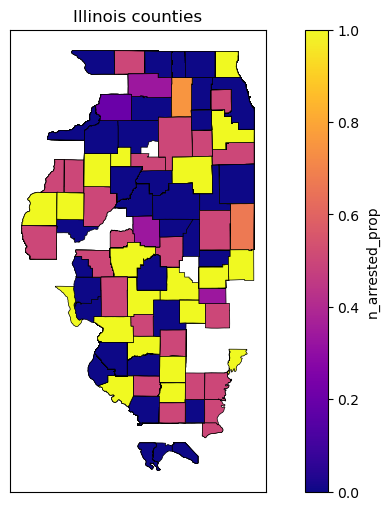

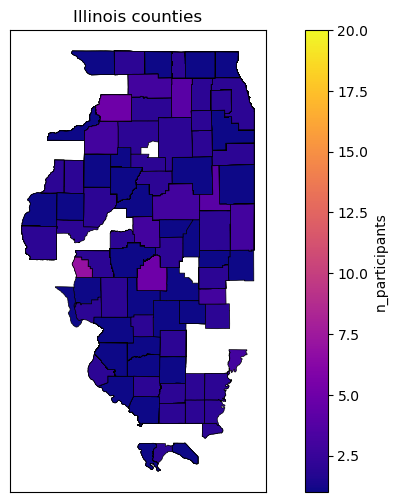

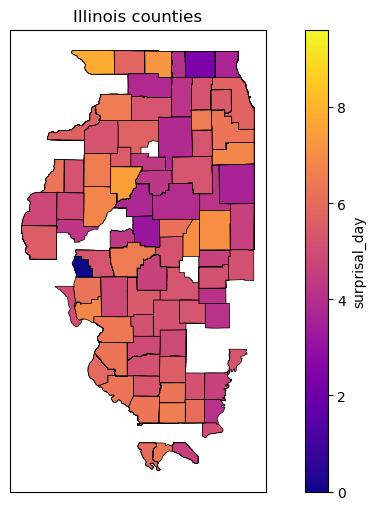

In [32]:
for column in ind_names_list:
    vmin, vmax = illinois_merged[column].agg(['min', 'max'])
    illinois_merged.plot(column=column, cmap='plasma', figsize=(10, 6), vmin=vmin, vmax=vmax,
        legend=True, legend_kwds={'label': column, 'shrink': 1}, edgecolor='black', linewidth=0.5)
    plt.title(f'Illinois counties')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [33]:
import geopandas
def plot_illinois_map(
    illinoise_df,
    col_to_plot,
    cmap='plasma',
    ):
    # select only illinois data
    illinois_df = illinoise_df[illinoise_df['state']=='ILLINOIS']

    # make county names uniform
    illinois_df['county'] = illinois_df['county'].str.replace(' County', '')
    illinois_df['county'] = illinois_df['county'].str.replace('Saint Clair', 'St. Clair')
    illinois_df['county'] = illinois_df['county'].str.replace('DeWitt', 'De Witt')

    # load map data
    illinois_map = geopandas.read_file('../cb_2018_us_county_500k') # todo
    illinois_merged = illinois_map.merge(illinois_df, left_on='NAME', right_on='county')
    illinois_merged = illinois_merged[illinois_merged['STATEFP']=='17']

    vmin, vmax = illinois_merged[col_to_plot].agg(['min', 'max'])
    illinois_merged.plot(column=col_to_plot, cmap=cmap, figsize=(10, 6), vmin=vmin, vmax=vmax,
        legend=True, legend_kwds={'label': col_to_plot, 'shrink': 1}, edgecolor='black', linewidth=0.5)
        
    plt.title(f'{col_to_plot} in Illinois counties')
    plt.xticks([])
    plt.yticks([])
    plt.show()